# Lab 4

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import astropy
import scipy
import astropy.constants as con
import astropy.units as u
import scipy.special
import scipy.signal
import matplotlib.cm as cm
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from matplotlib.patches import Rectangle
from astropy.io import fits
import os
import scipy.interpolate
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from matplotlib.colors import TwoSlopeNorm


In [2]:
import ugradio

No module named 'rtlsdr'


In [3]:
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.linewidth'] = 1

In [4]:
def calc_gain(main_data, on_data, off_data):
    
    """
    A simple function to compute the gain for a given coordinate.
    """    
    
    T_NOISE = 90 # Kelvin
    G = (T_NOISE/(np.sum(on_data-off_data))) * np.sum(off_data) #calc Gain
    
    return G


def calc_velocities():
    
    """
    A simple function to calculate the velocities
    """
    
    FREQ_RES = 8192 
    LO = 1270 #Mhz
    RF = 1420.4058 #Mhz
    c = 3e5 #km/s
    freqs = np.linspace(144,156,FREQ_RES) 
    velocities = (((freqs+LO)-RF)/RF)*c #doppler velocities
    
        
    return velocities
    

def calc_peak_max(main_file, on_file, off_file, l_b_RA_DEC_JD):
    
    """
    A function that takes in 3 observational files and performs
    the calibration to convert to temperature and then returns
    the maximum temperature [K] of that coordinate as well as the 
    corresponding velocity [km/s].
    """
#     on=fits.open(main_fits,memmap=True, do_not_scale_image_data=True)[0].header
    l, b, RA, DEC, JD = l_b_RA_DEC_JD
    correction = ugradio.doppler.get_projected_velocity(RA, DEC,JD).value / 1000
    main_data = main_file[10:-10]
    on_data = on_file[10:-10]
    off_data = off_file[10:-10]
    #print(correction)
    T_NOISE = 90 # Kelvin
    
    G = calc_gain(main_data,on_data,off_data)
    max_value = np.max((main_data/off_data))
    max_index = np.argmax((main_data/off_data))
    velocities = calc_velocities()+correction
    
    
    fitting_indeces = np.where((velocities > -70) & (velocities < 50)) # we zoom in to ignore the ripples
    G = calc_gain(main_data,on_data,off_data)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities
    x_data_fit = x_data_fit[fitting_indeces]
    max_value = np.max(y_data_fit[np.where(x_data_fit<40)])
    max_index = np.argmax(y_data_fit[np.where(x_data_fit<40)])
    T = max_value
    vel = x_data_fit[max_index]
    plt.plot(x_data_fit,y_data_fit)
    plt.vlines(vel,0,T)
    plt.ylabel('Temperature(K)')
    plt.xlabel('Velocity(km/s)')
    plt.title(str(l) + '_' + str(b))
    plt.show()
    return T, vel

def calc_peak_gaussian(main_file, on_file, off_file):
    
    """
    A function to compute the Temperature [K] and Velocity [km/s] 
    at the peak using a gaussian fit.
    """
    
    main_data = main_file[10:-10]
    on_data = on_file[10:-10]
    off_data = off_file[10:-10]
    
    velocities = calc_velocities()
    
    fitting_indeces = np.where((velocities > -50) & (velocities < 50)) # we zoom in to ignore the ripples
    G = calc_gain(main_data,on_data,off_data)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities
    x_data_fit = x_data_fit[fitting_indeces]
    

    fit_params = ugradio.gauss.gaussfit(x_data_fit, 
                                        y_data_fit, 
                                        amp=np.max(y_data_fit),
                                        avg=x_data_fit[np.argmax(y_data_fit)],
                                        sig=10) #get fit
    
    
    T, vel = fit_params['amp'][0], fit_params['avg'][0]
                 
    return T,vel

def calc_avg_power_fft(data):
    fft = np.fft.fft(data)
    pow_data = np.abs(fft)**2
    avg_data = np.mean(pow_data, axis=1)
    return np.fft.fftshift(avg_data)

def calc_avg(data):
    return np.mean(data, axis=1)

def calc_median_power_fft(data):
    fft = np.fft.fft(data)
    pow_data = np.abs(fft)**2
    avg_data = np.median(pow_data, axis=1)
    return np.fft.fftshift(avg_data)

def calc_freq(samples, frequency):
    return np.fft.fftshift(np.fft.fftfreq(samples, d=1/frequency))


In [5]:
# (l = 105◦ to 160◦),(b = 15◦ to 50◦)

dg = u"\N{DEGREE SIGN}"

def plot_FOV(ax, color, label):
    
    FOV = (2 * (np.pi/180))/ 2 #set by the telescope. We have a 2 degree field of view
    n = 10
    xarr = np.arange(105, 160, 2)
    yarr = np.arange(15, 50, 2)
    for i in range(len(xarr)):
        for j in range(len(yarr)):
            x, y = xarr[i], yarr[j]
            gal = SkyCoord(x*u.degree, y*u.degree, frame='galactic')
            ra_dec = gal.transform_to('fk5')
#             print(ra_dec)
        #     gal = eq.galactic
        #     print(gal.l)

        #     ax.scatter(gal.l,gal.b,alpha=0.5,marker="s",s=200,color=color, label=label)
            ax.add_patch(Rectangle((ra_dec.ra.wrap_at('180d').radian - FOV, ra_dec.dec.radian - FOV),FOV*2 , FOV*2,
                         edgecolor = color,
                         facecolor = color,
                         alpha=0.5,
                         fill=True,
                         lw=3))
    
# plot_FOV(ax, RA_z, DEC_z, color="blue", label="Calibration")

Text(0, 0.5, 'Declination')

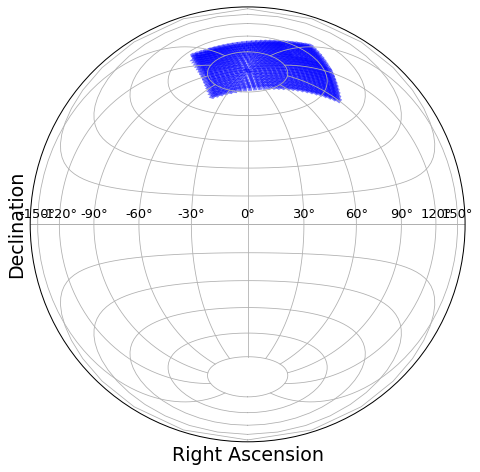

In [6]:
f = plt.figure(figsize=(20,8))

ax = plt.subplot(111, projection='lambert')
ax.grid(True)

plot_FOV(ax, color="blue", label="Target")
ax.set_xlabel('Right Ascension', fontsize=19)
ax.set_ylabel('Declination', fontsize=19)

In [7]:
import matplotlib
matplotlib.projections.get_projection_names()

['3d', 'aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear']

## Process coordinate data from Darby's folder

In [8]:
# SCRIPT TO COMPRESS TO NUMPY ARRAYS
# import os
# from astropy.io import fits

# for filename in os.listdir(os.getcwd()):
#     if filename == ".ipynb_checkpoints":
#         continue
#     split_name = filename.split("_")
#     if split_name[0] != 'celestial':
#         continue

#     if split_name[2] == 'off':
#         prefix = 'off' # off
#     elif splits_name[2] == 'on':
#         prefix = 'on' # on
#     else:
#         prefix = 'main' # main

#     l, b = split_name[-1].split(" , ")
#     b = b.split('.fits')[0]
#     num_l, num_b = float(l), float(b) # convert strings to floats

#     fits_data = fits.open(filename)
#     data_arr = np.zeros((8192, len(fits_data)-1))

#     for i in range(1, len(fits_data)):
#         data_arr[:,i-1] = fits_data[i].data['auto0_real']
    
#     new_filename = os.getcwd() +'/celestial_data/' + prefix + '_' + l + '_' + b + '_.fits'
#     np.save(data_arr, new_filename)
    
        

In [9]:
# currently not used, but maybe this would be neater?
class Observation:
    def __init__(self, main, on, off, l, b, ra, dec, jd):
        self.main = main
        self.on = on
        self.off = off
        self.coord = (l, b)
        self.ra = ra
        self.dec = dec
        self.jd = jd
        self.l = l
        self.b = b
    

## CODE TO LOAD .npy TO DICTIONARY AND EXTRACT INFO FROM FILENAMES

In [10]:
# CODE TO LOAD SPECTRA NUMPY FILES IN A DICT
bad_coords = [[134.7272, 29], [131.0726490577271,23], [135.332468, 31], 
              [129.41549,35], [105, 33], [134.18048, 27], [134.2985, 35],
              [132.9992, 31], [132.440497, 29]]

data_dict = {} # dict where key is coordinate (l, b)) and value is [main, noise_on, noise_off, [ra, dec, jd]]
                # where main, noise_on, noise_off are all numpy arrays of the spectra
for filename in os.listdir(os.getcwd() + '/celestial_data'):
    if filename == ".ipynb_checkpoints" or filename == '.DS_Store':
        continue
    split_name = filename.split("_")
    
    skip = False
    if split_name[0] == 'off':
        fits_type = 2 # off
    elif split_name[0] == 'on':
        fits_type = 1 # on
    else:
        fits_type = 0 # main

    #l, b, ra, dec, jd
    _, l, b, ra, dec, jd, _ = split_name
    l, b, ra, dec, jd = float(l), float(b), float(ra), float(dec), float(jd) # convert strings to floats
    
    for bad_l, bad_b in bad_coords:
        if int(l) == int(bad_l) and int(b) == int(bad_b):
            print(l, b)
            skip = True
            break
    
    if skip:
        continue 
        
    curr_data = np.load('celestial_data/' + filename) # load the spectra from file
    curr_data = calc_avg(curr_data) # keep the avg in the dict
    
    if not data_dict.get((l, b)):
        data_dict[(l, b)] = [[], [], [], ra, dec, jd]      
    data_dict[(l, b)][fits_type] = curr_data
print(len(data_dict.keys()))

134.7272057647063 29.0
131.0726490577271 23.0
135.3324683275986 31.0
129.4154917752291 35.0
105.0 33.0
135.3324683275986 31.0
105.0 33.0
134.1804821784934 27.0
129.4154917752291 35.0
134.2985901302749 35.0
131.0726490577271 23.0
134.2985901302749 35.0
131.0726490577271 23.0
132.9992015331679 31.0
132.4404976289597 29.0
134.7272057647063 29.0
132.9992015331679 31.0
135.3324683275986 31.0
132.9992015331679 31.0
134.1804821784934 27.0
132.4404976289597 29.0
134.2985901302749 35.0
134.7272057647063 29.0
129.4154917752291 35.0
134.1804821784934 27.0
132.4404976289597 29.0
105.0 33.0
392


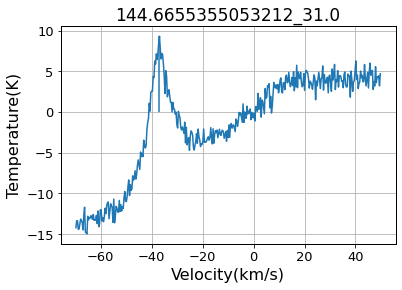

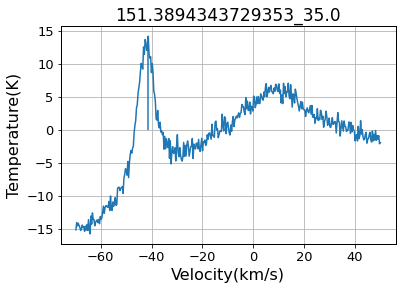

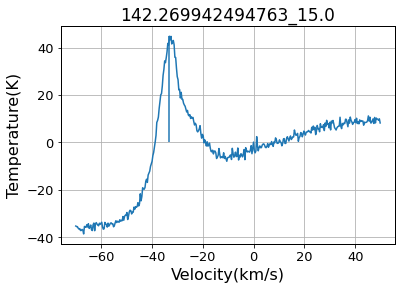

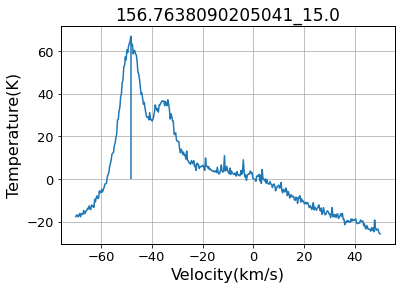

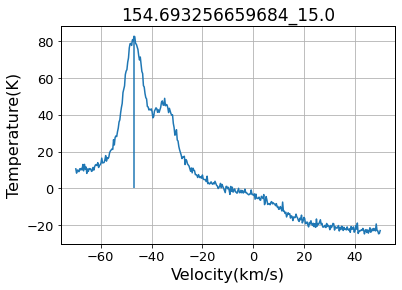

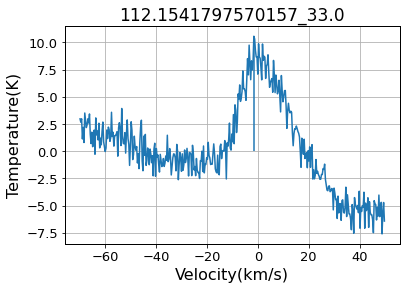

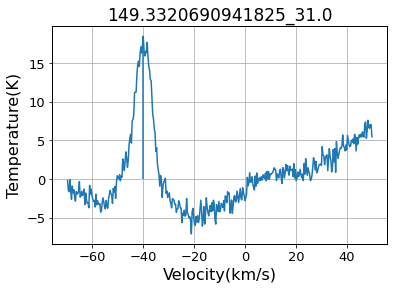

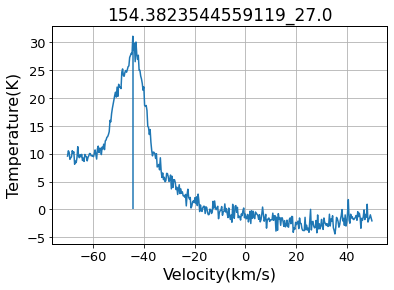

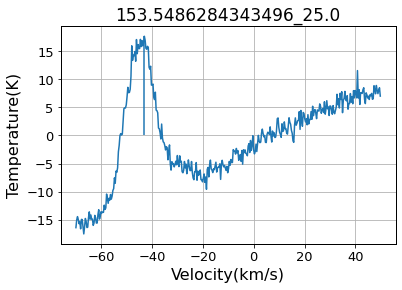

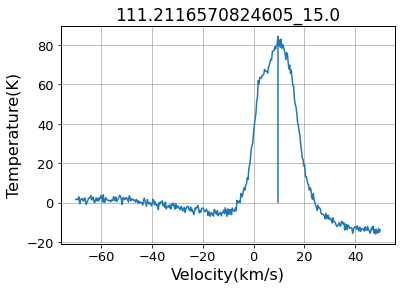

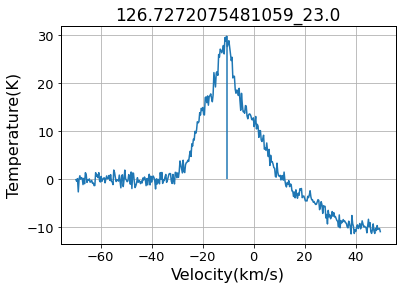

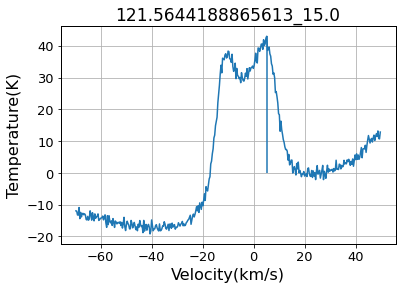

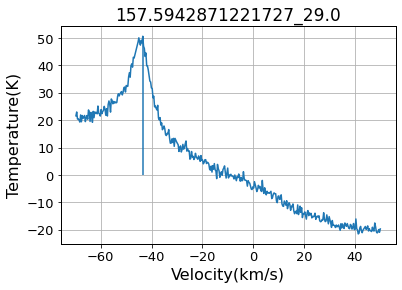

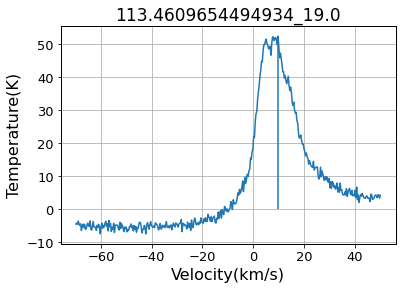

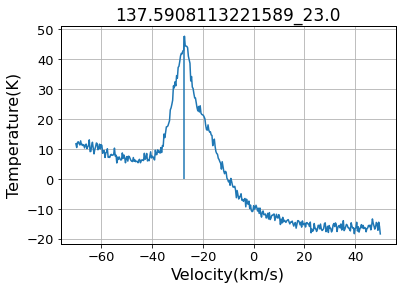

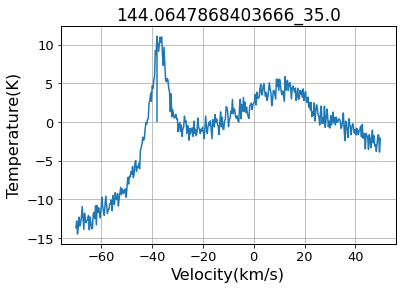

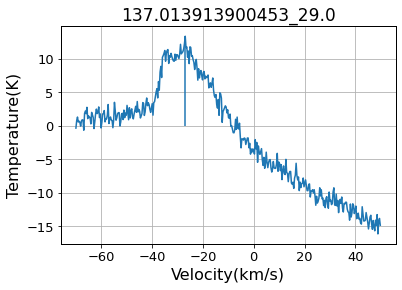

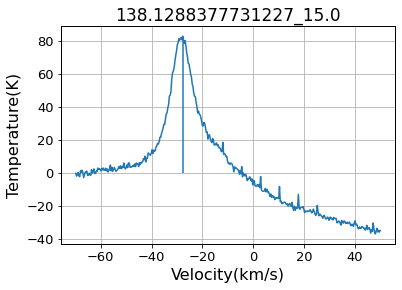

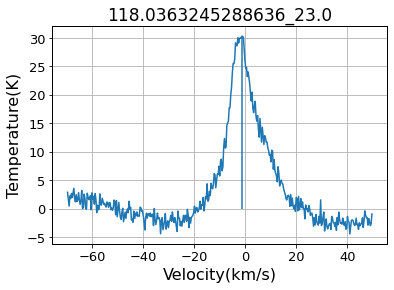

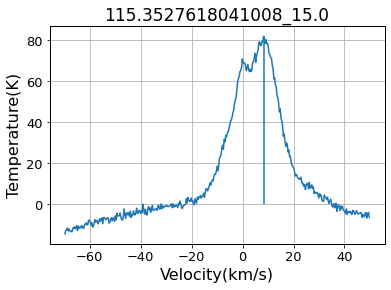

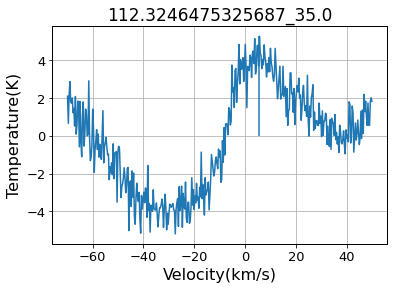

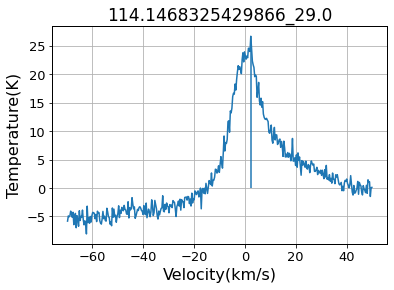

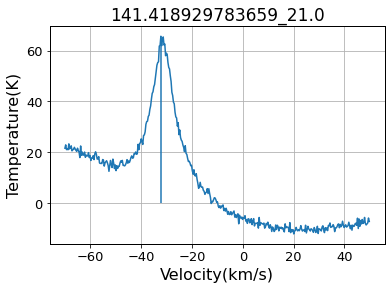

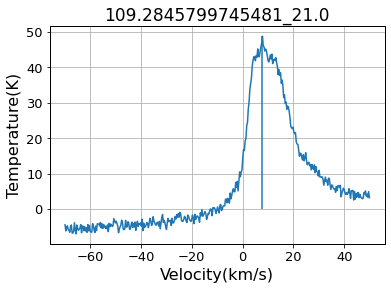

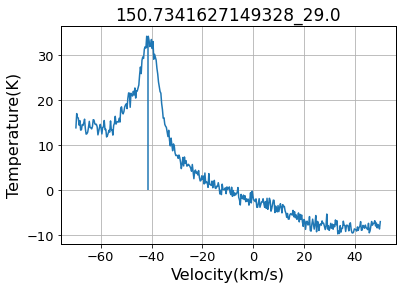

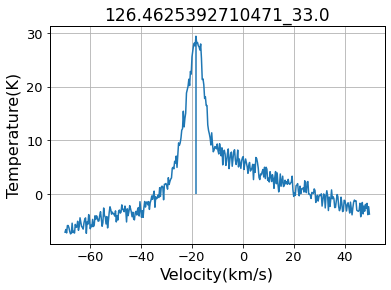

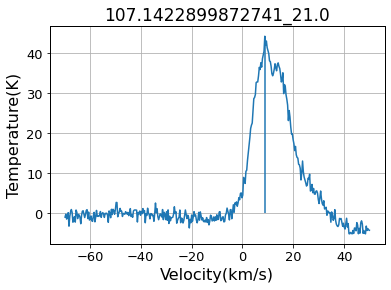

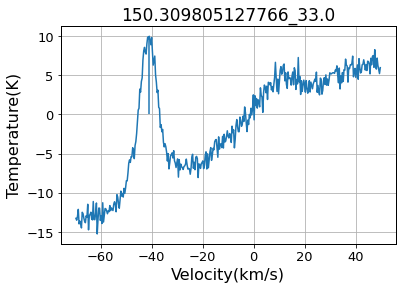

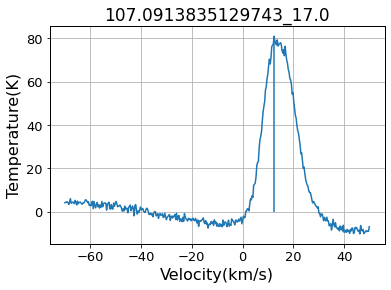

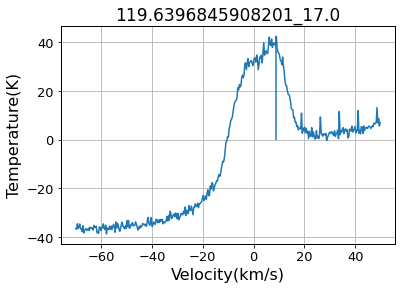

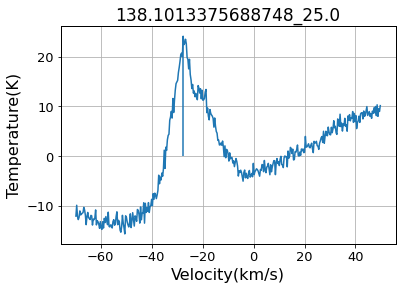

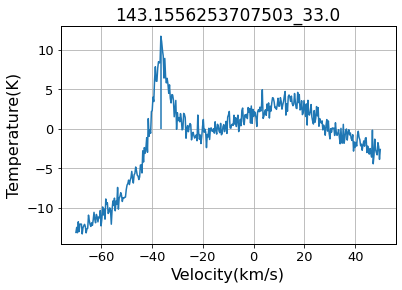

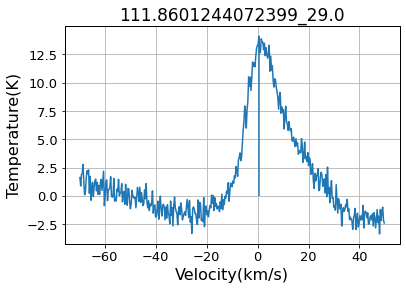

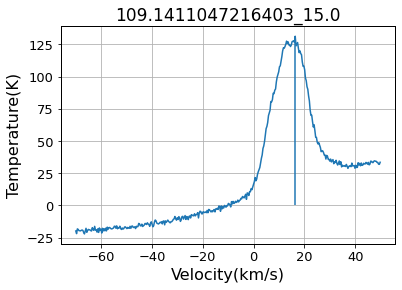

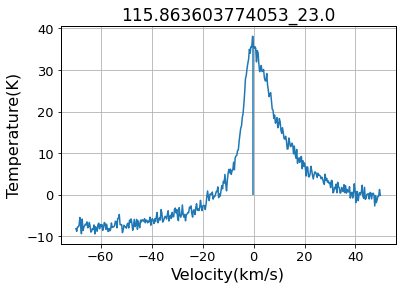

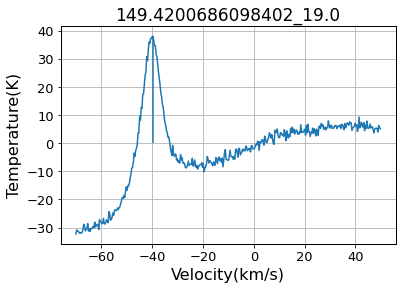

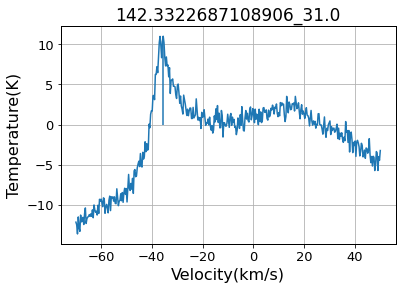

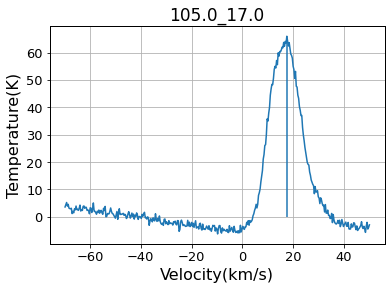

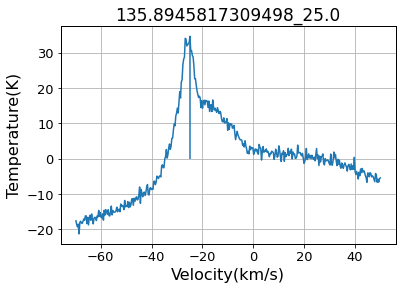

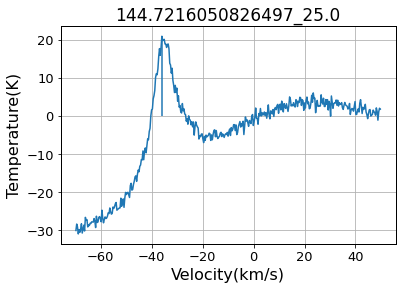

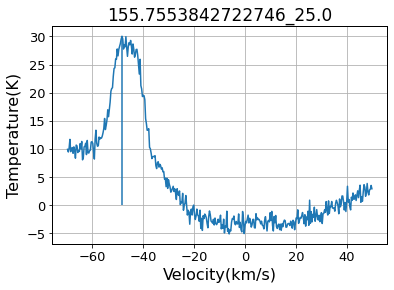

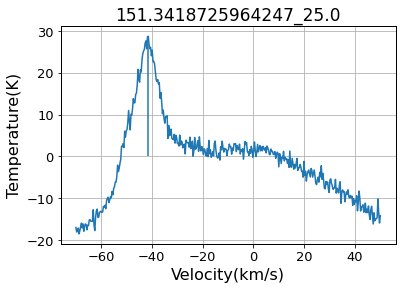

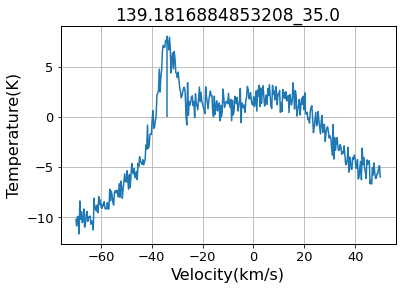

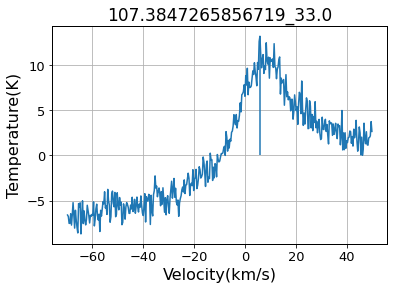

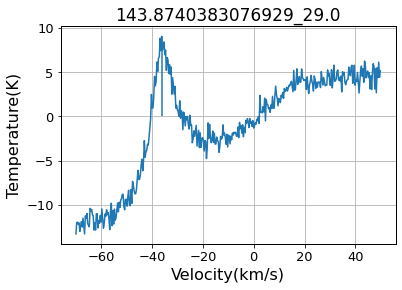

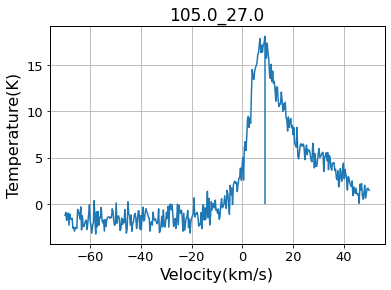

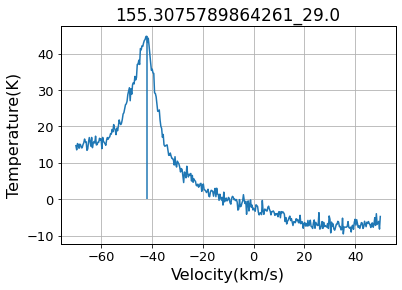

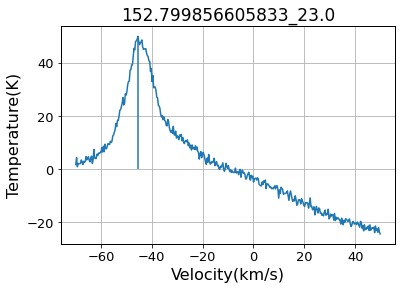

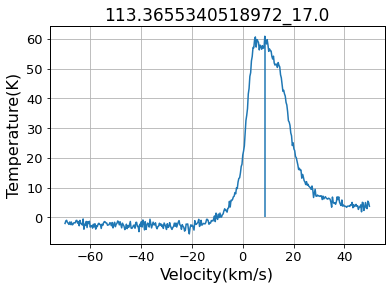

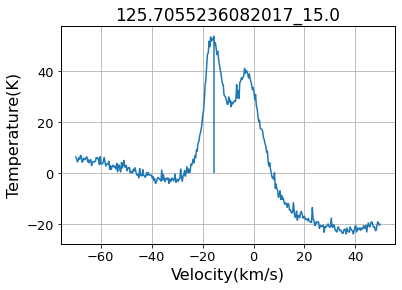

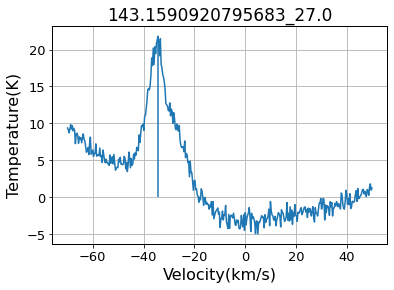

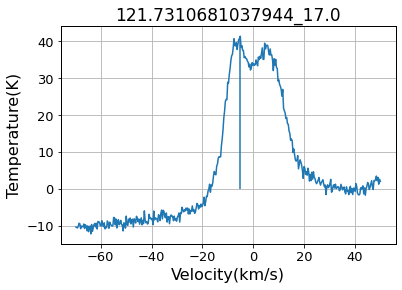

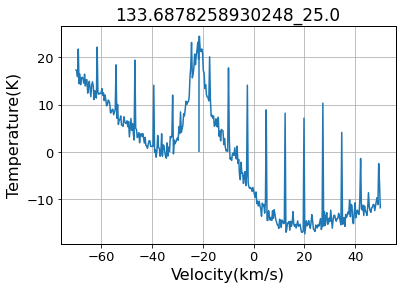

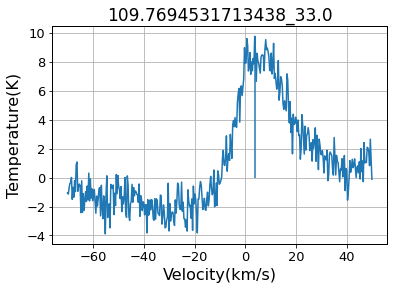

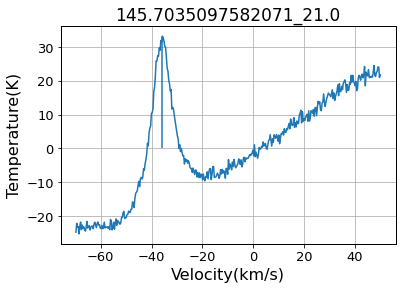

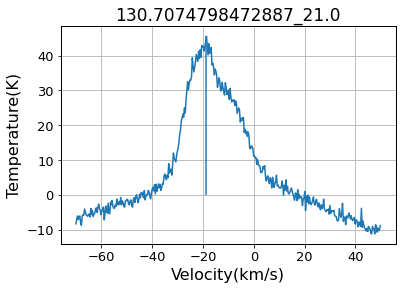

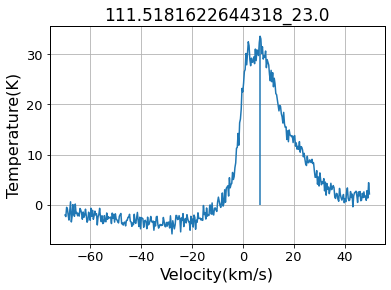

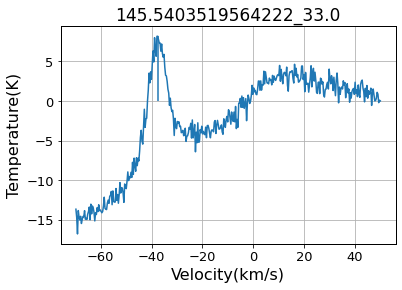

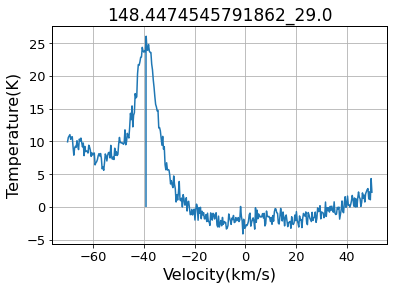

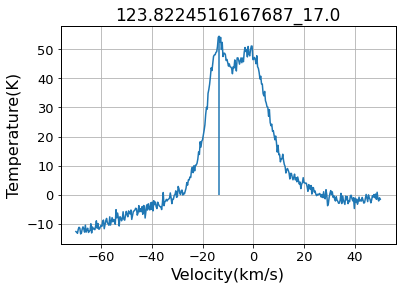

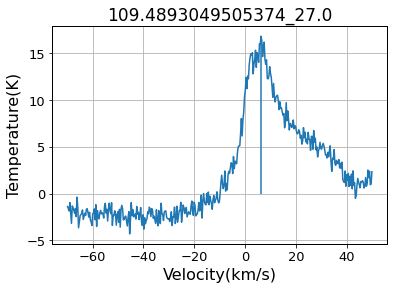

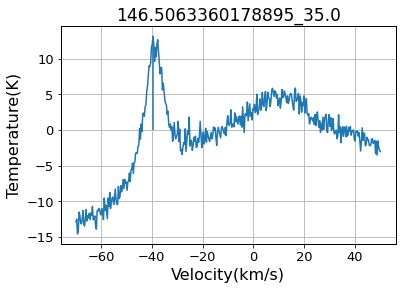

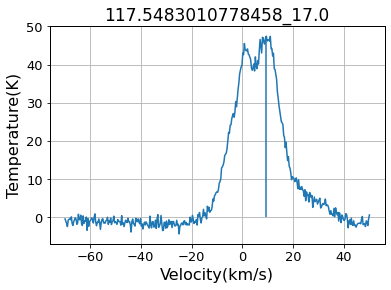

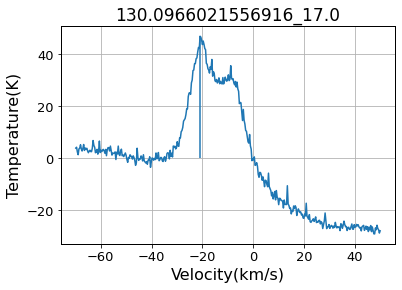

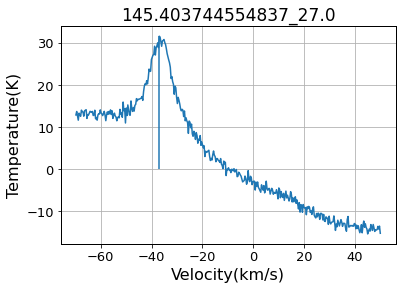

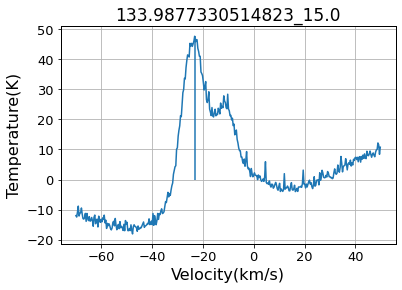

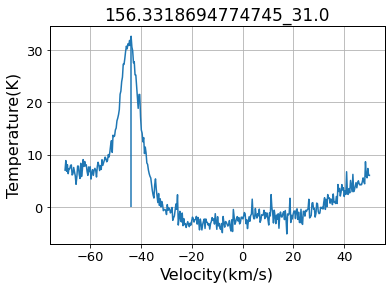

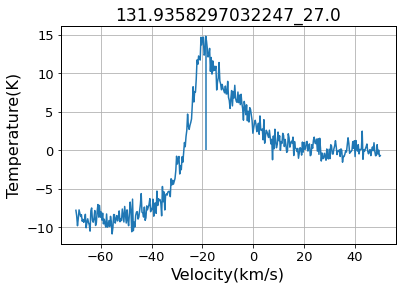

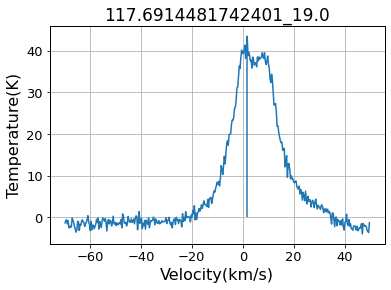

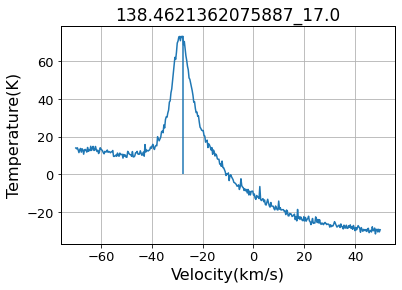

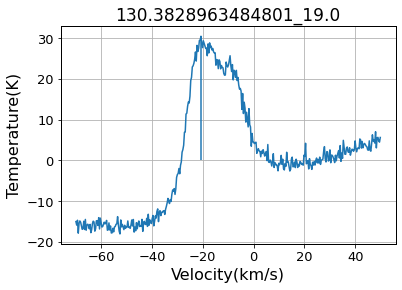

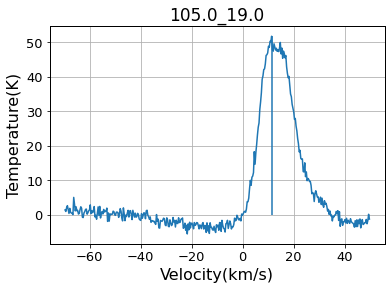

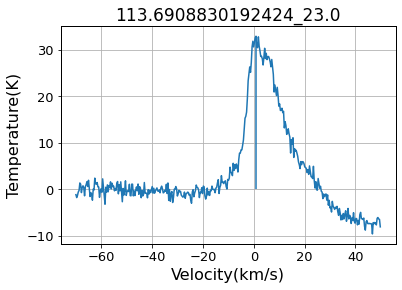

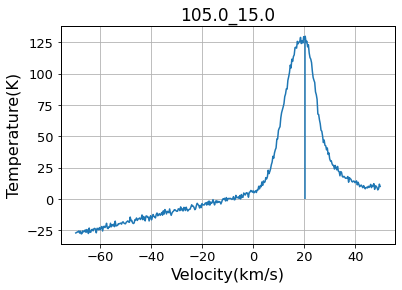

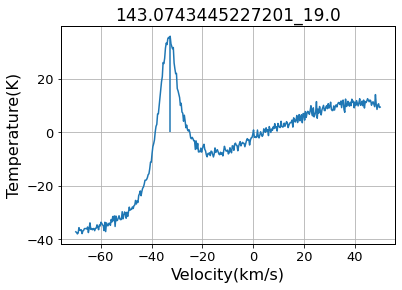

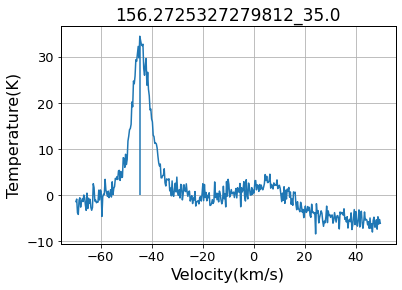

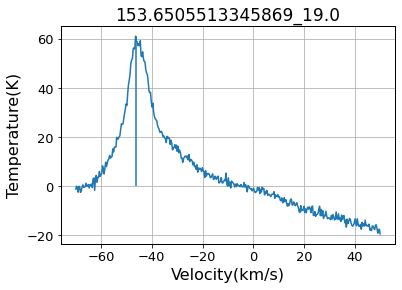

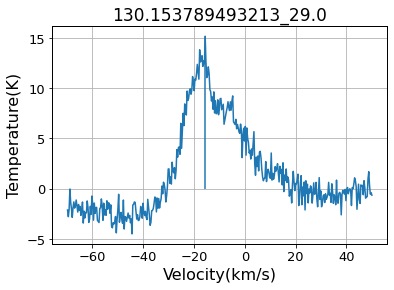

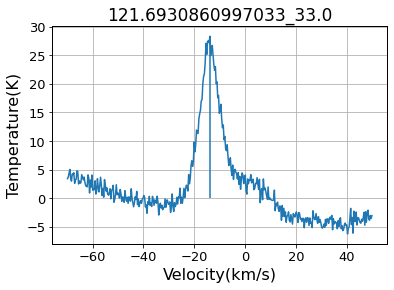

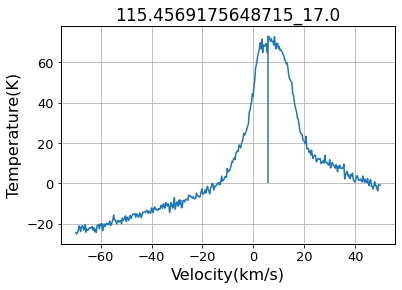

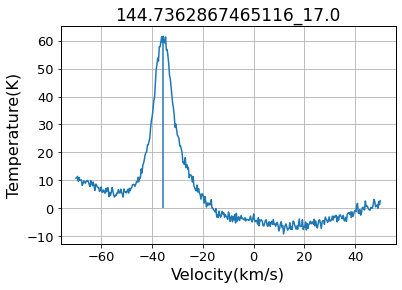

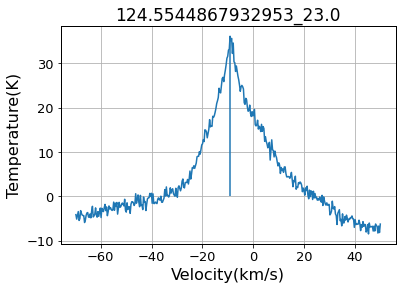

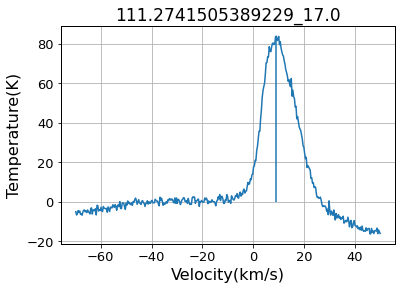

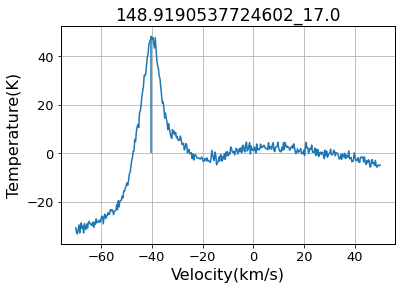

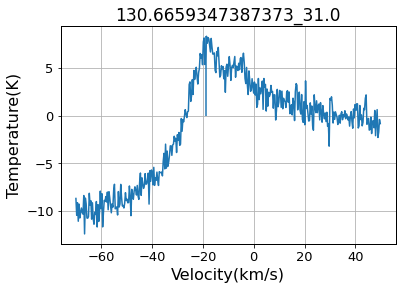

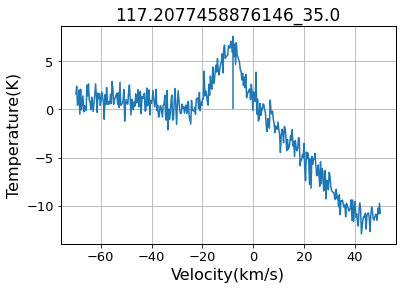

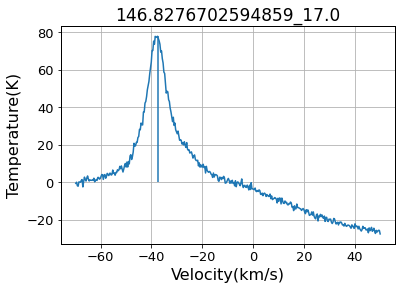

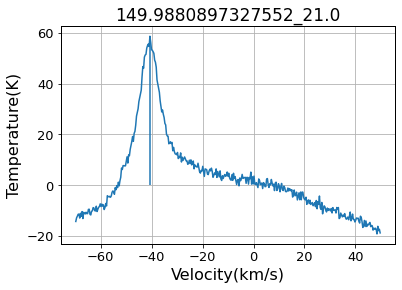

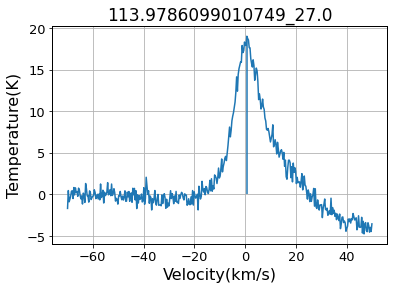

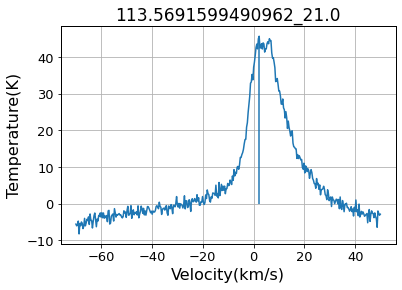

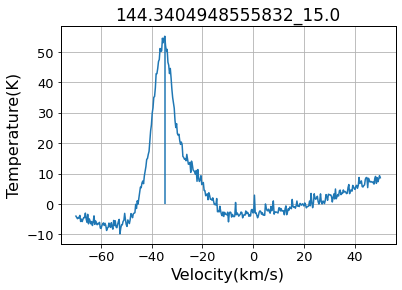

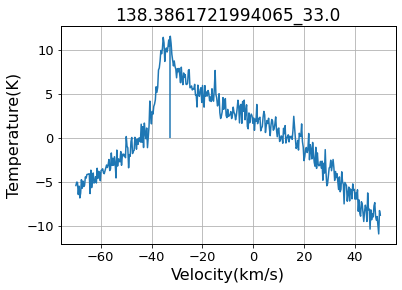

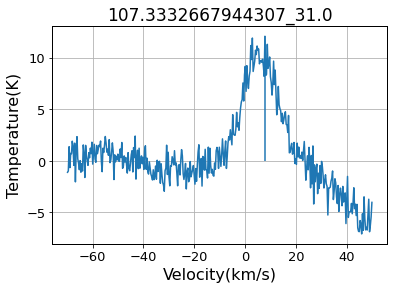

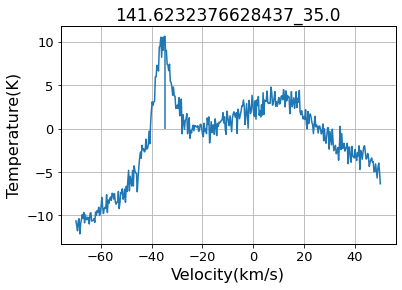

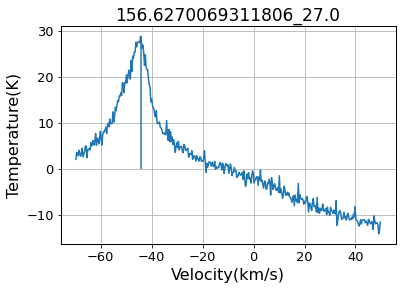

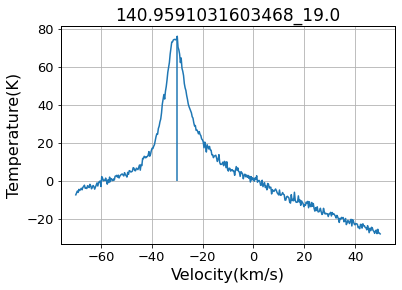

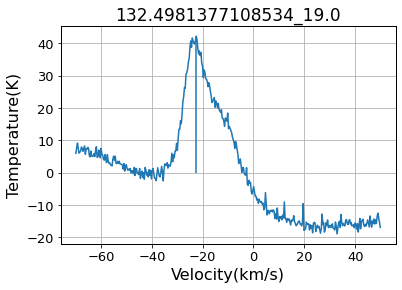

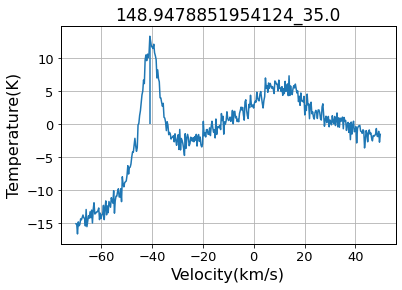

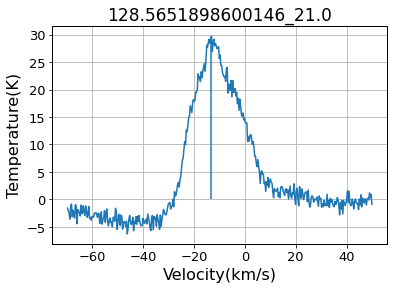

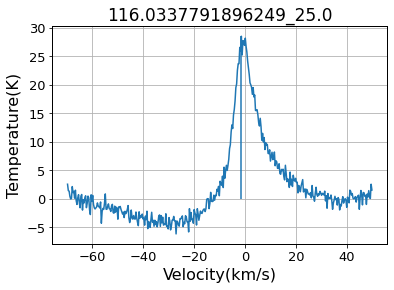

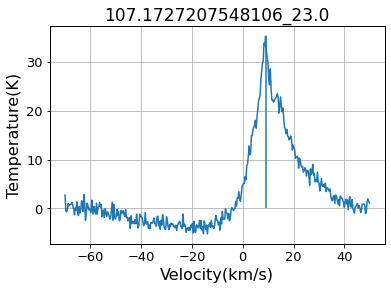

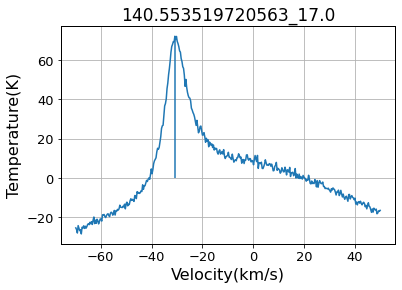

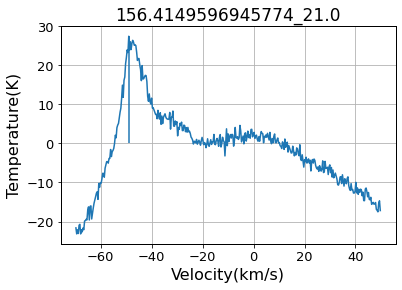

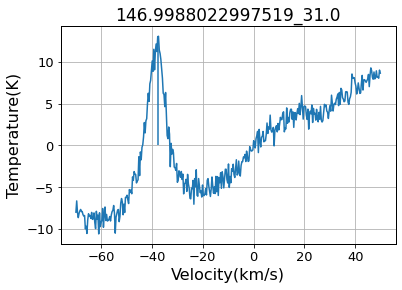

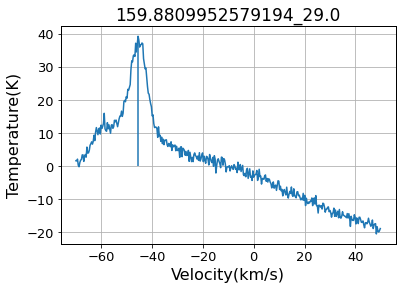

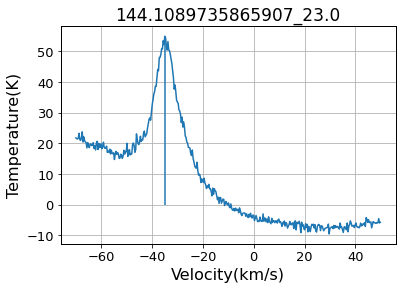

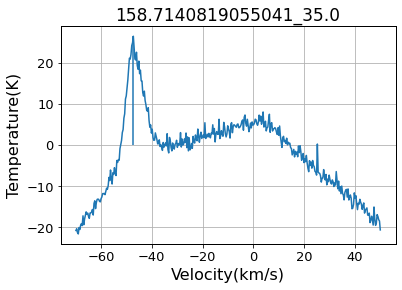

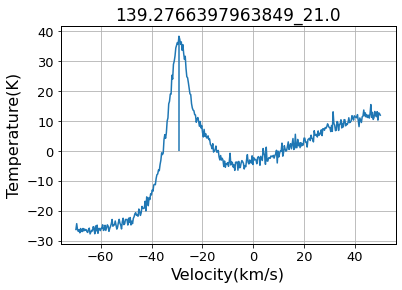

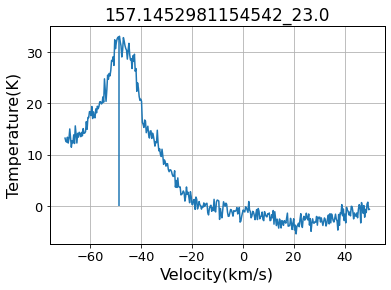

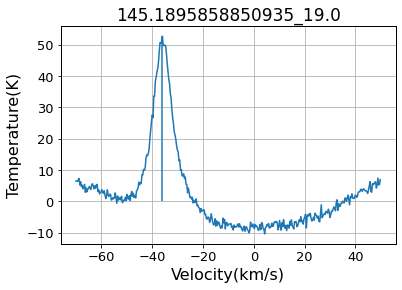

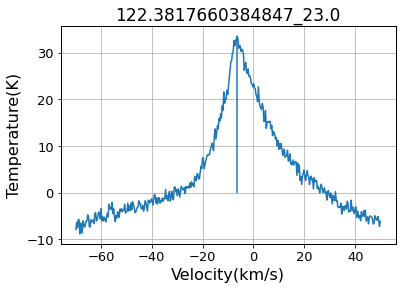

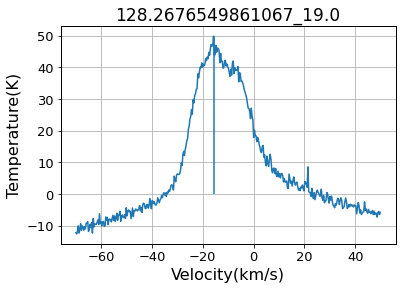

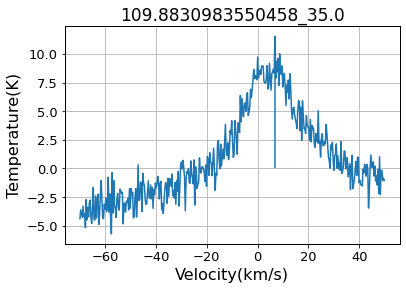

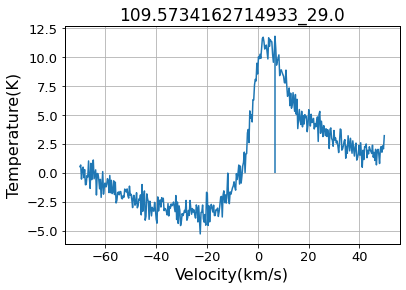

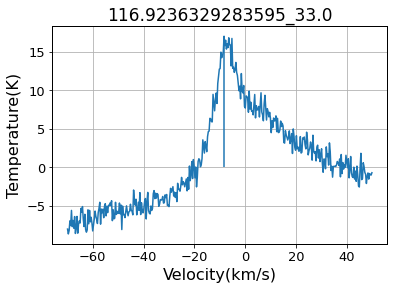

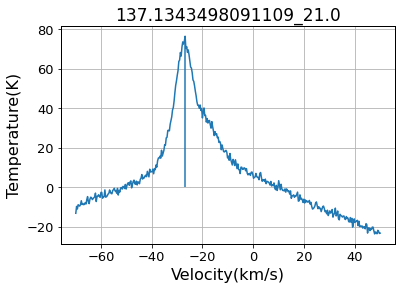

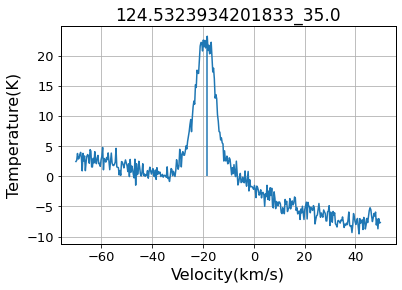

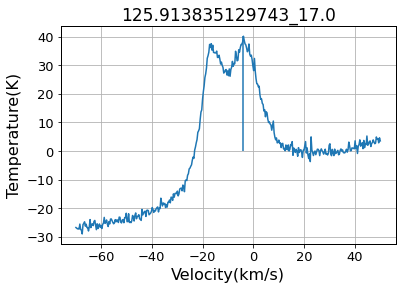

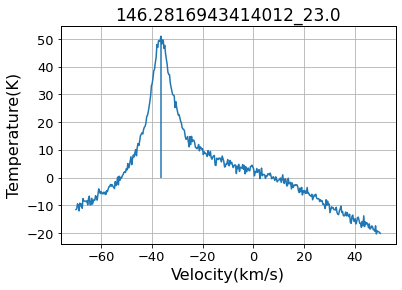

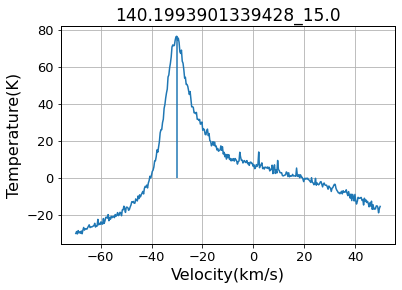

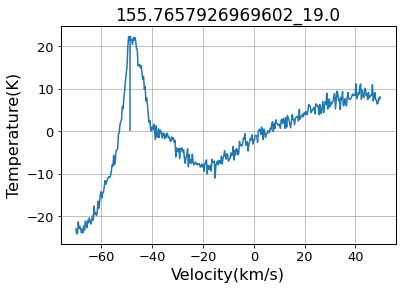

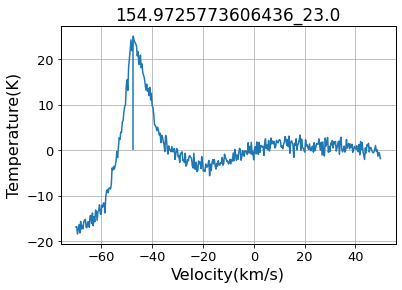

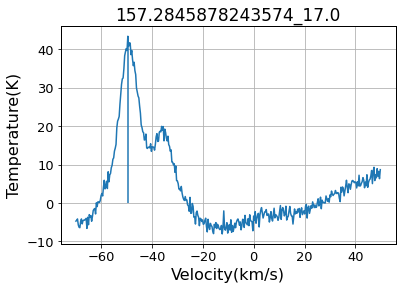

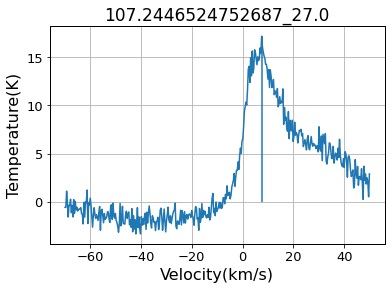

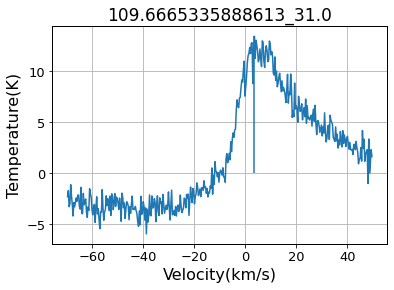

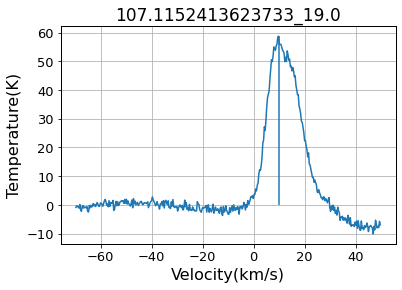

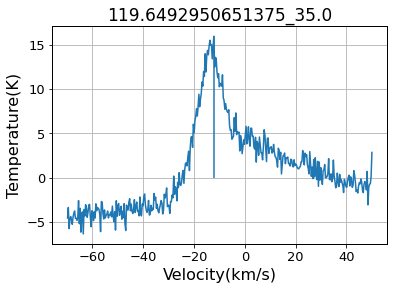

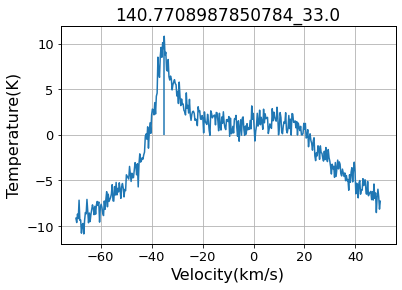

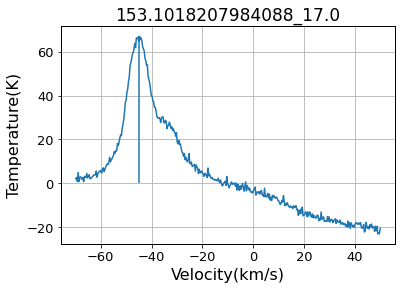

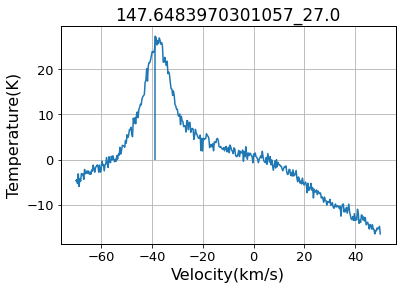

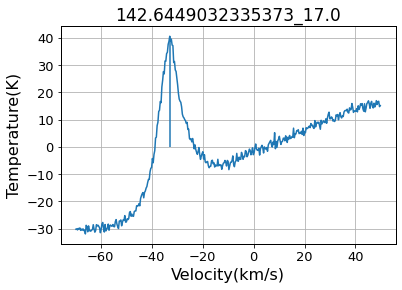

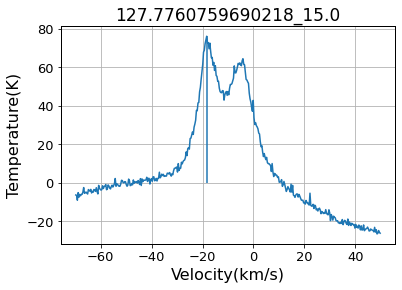

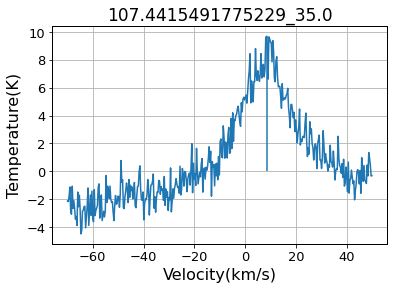

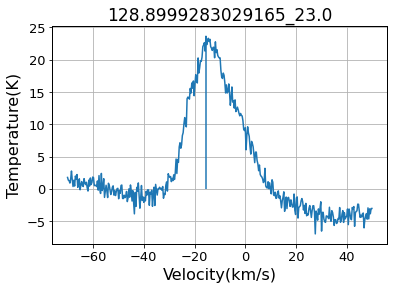

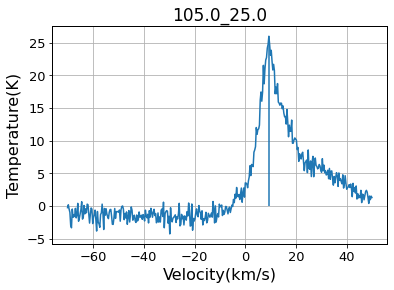

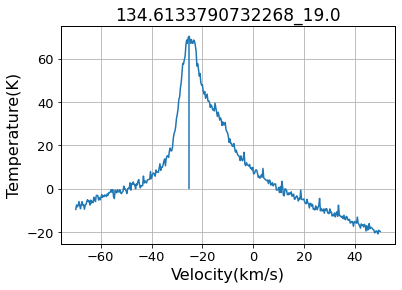

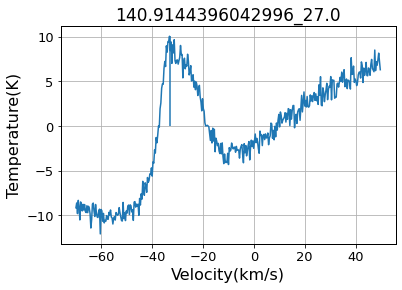

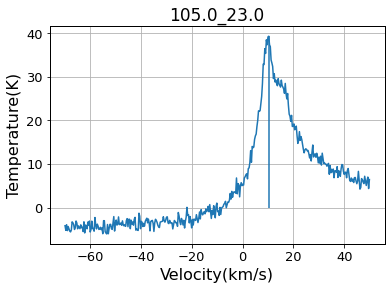

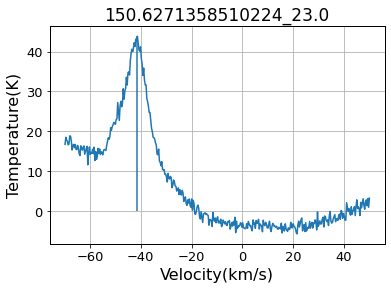

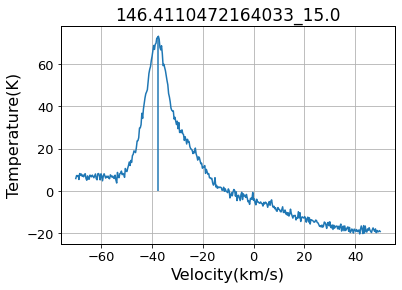

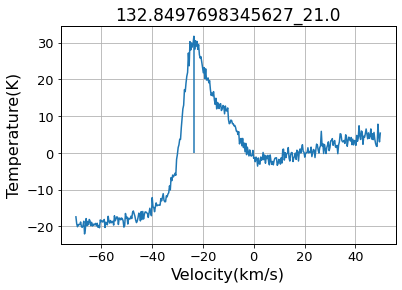

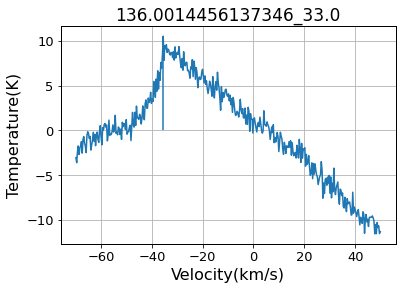

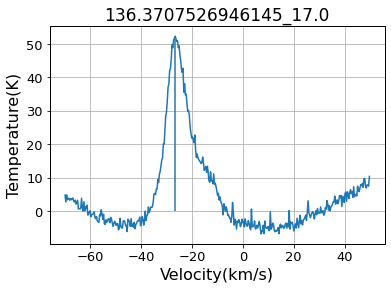

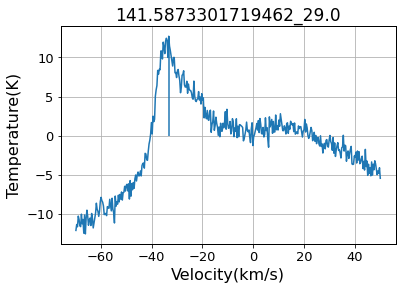

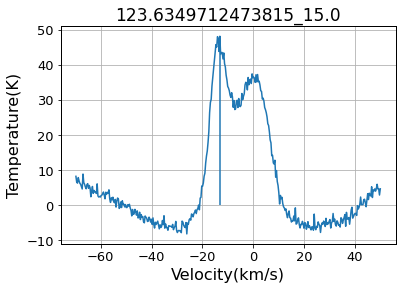

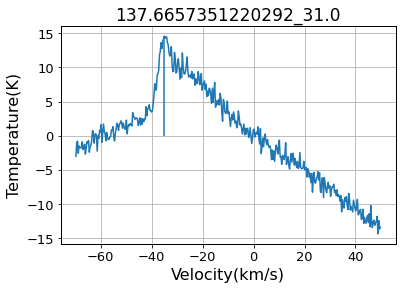

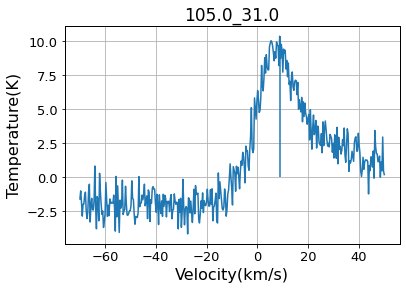

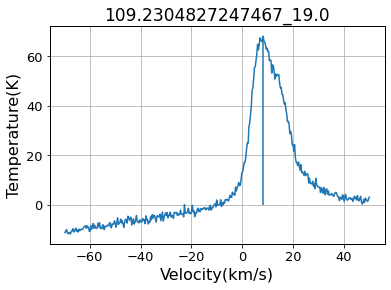

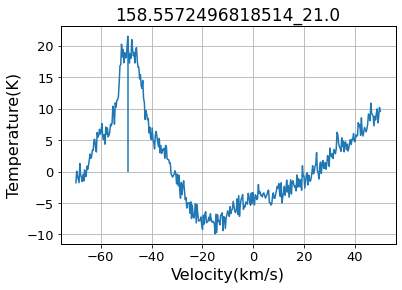

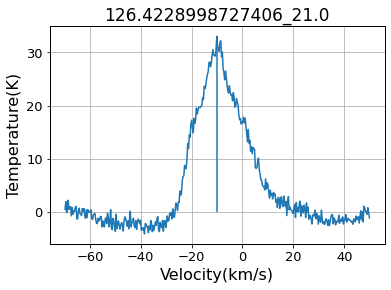

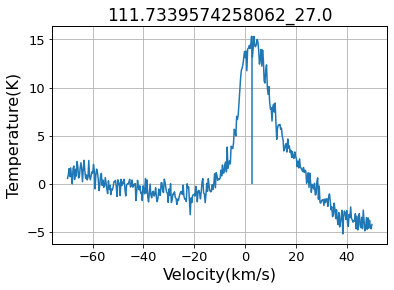

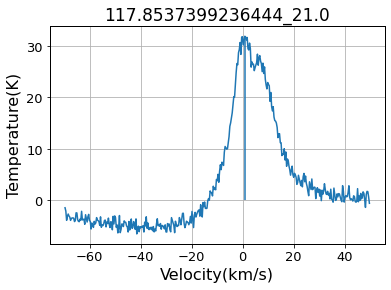

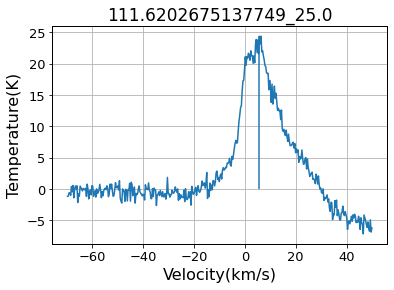

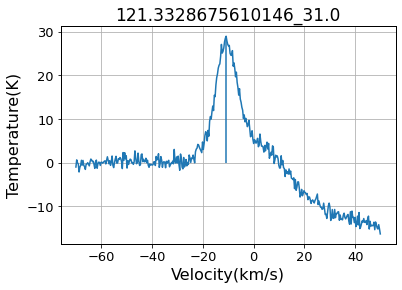

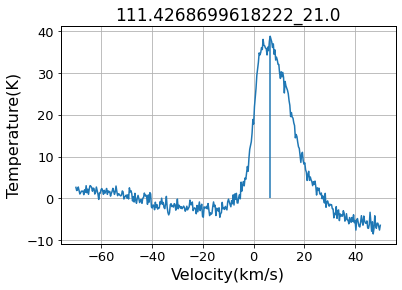

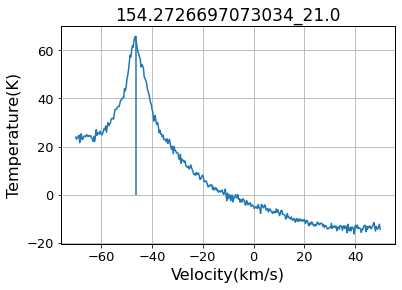

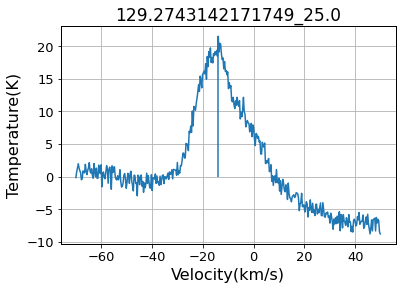

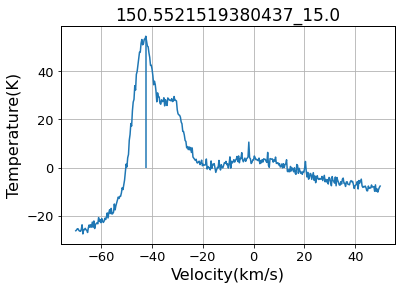

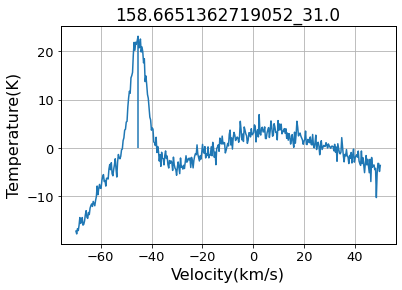

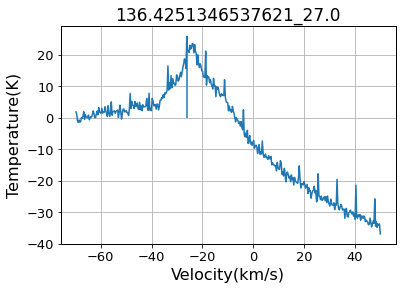

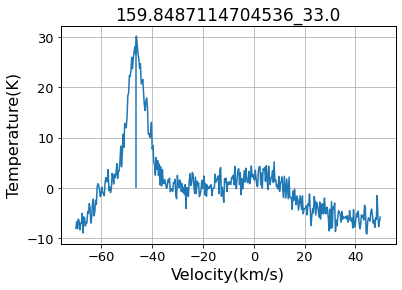

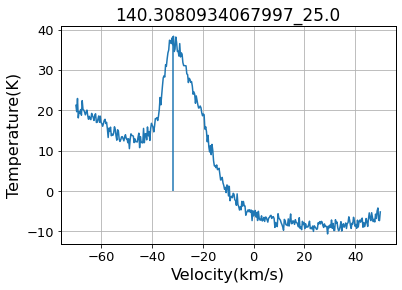

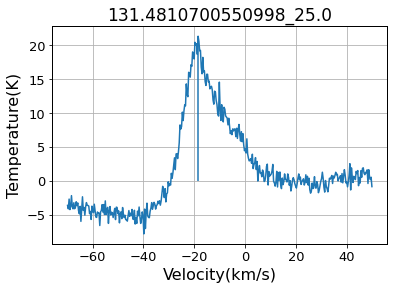

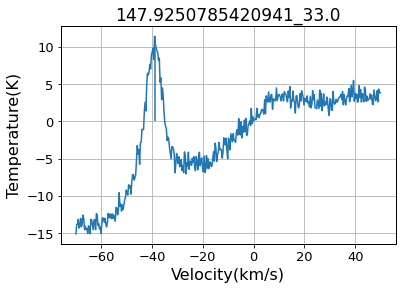

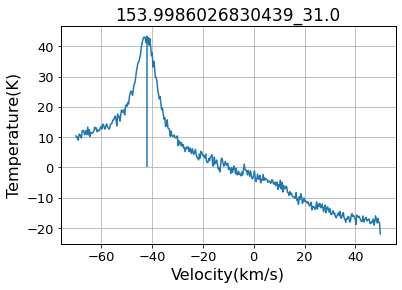

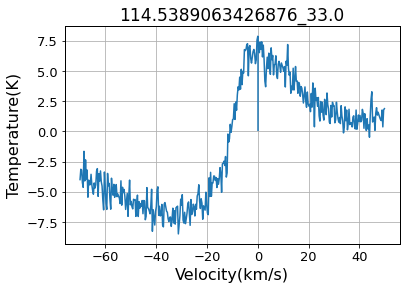

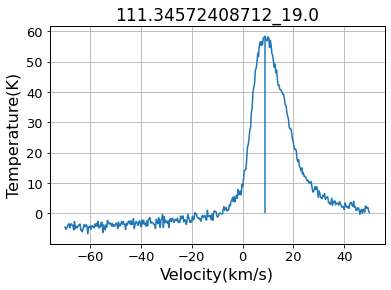

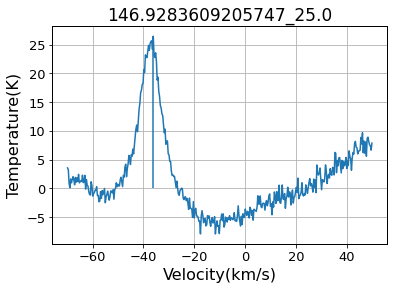

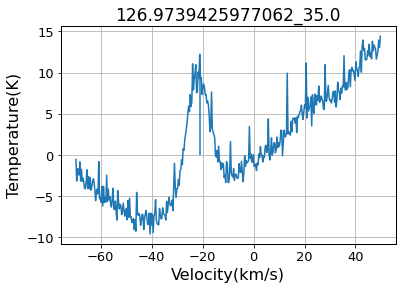

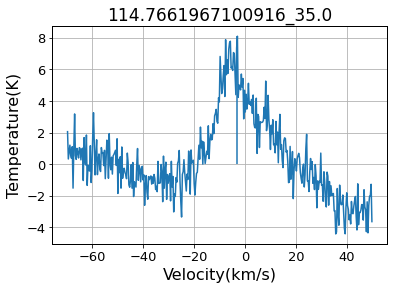

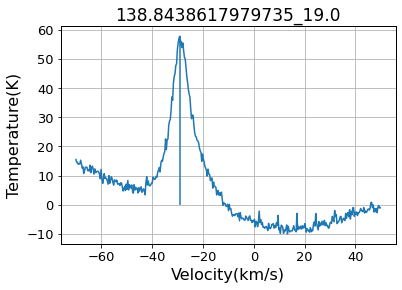

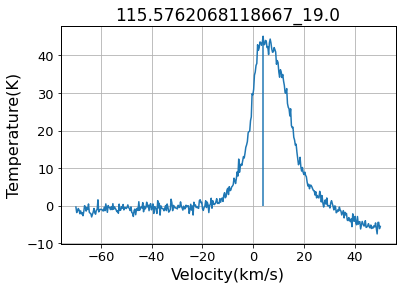

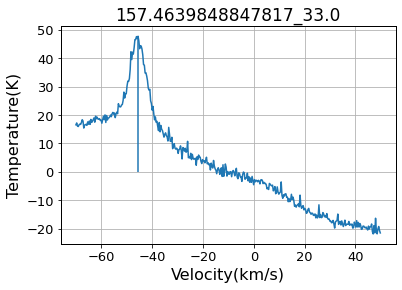

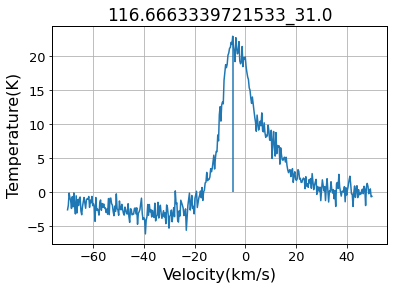

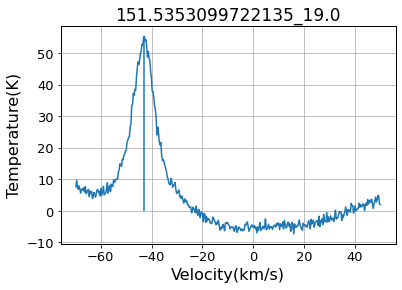

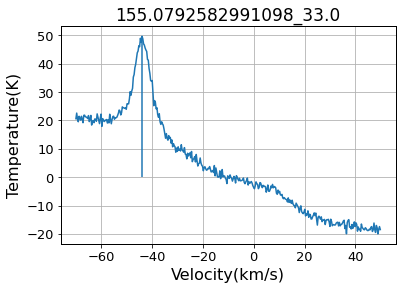

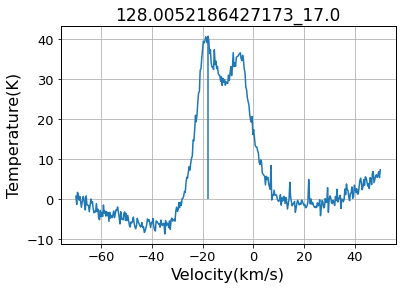

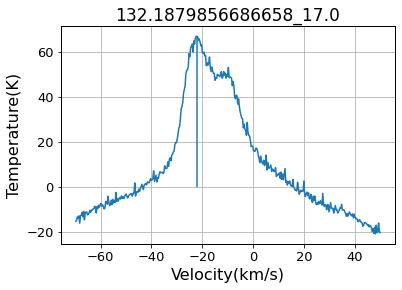

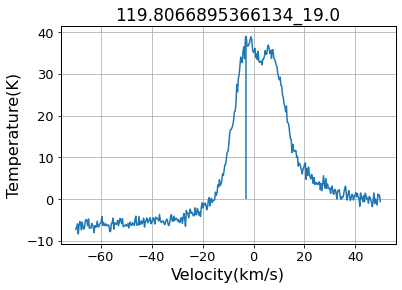

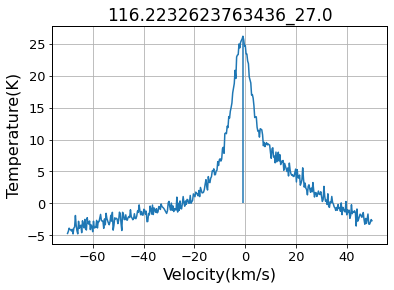

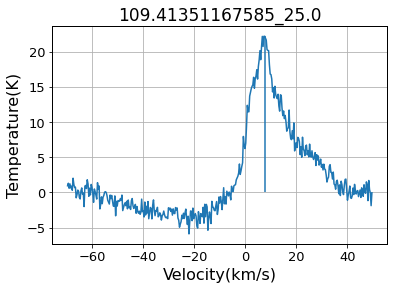

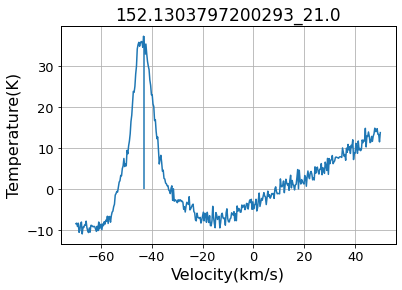

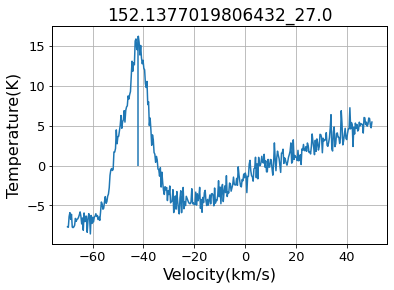

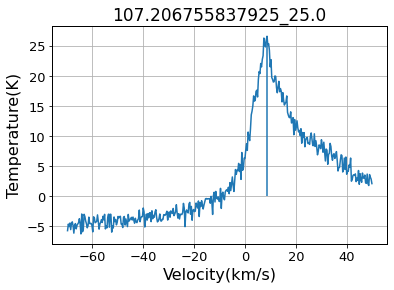

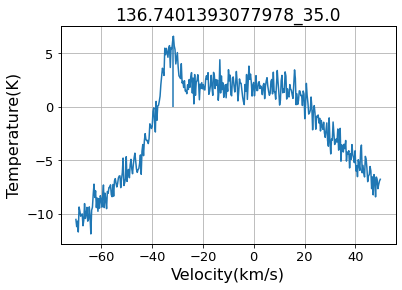

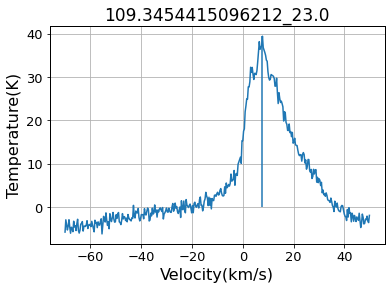

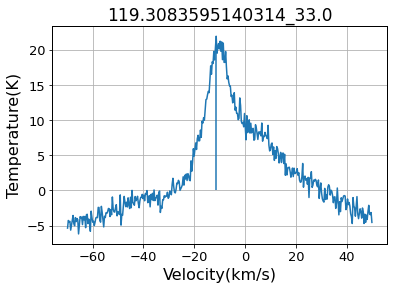

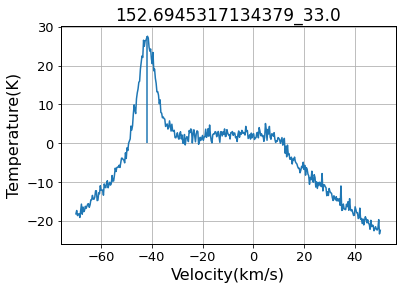

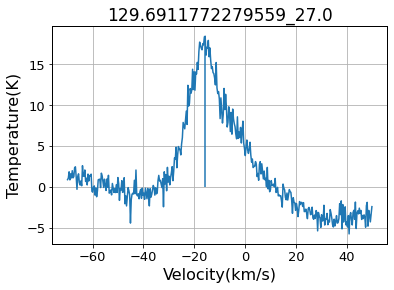

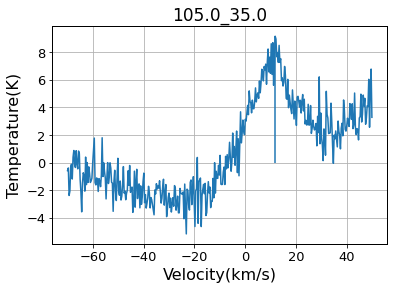

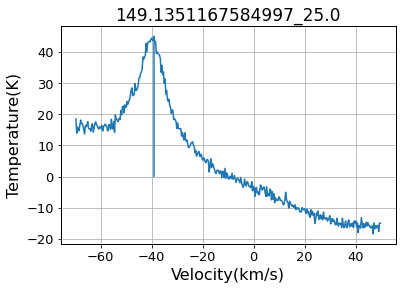

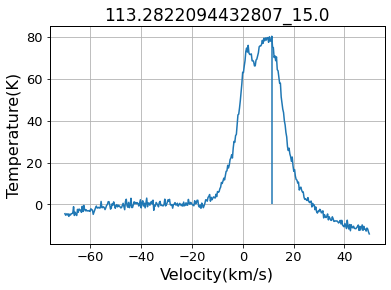

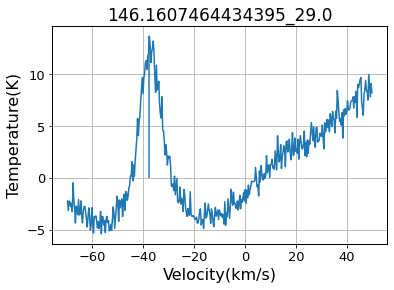

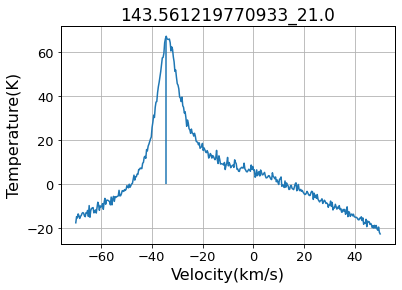

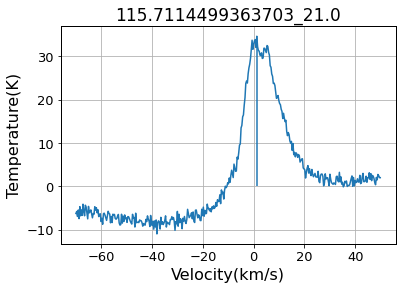

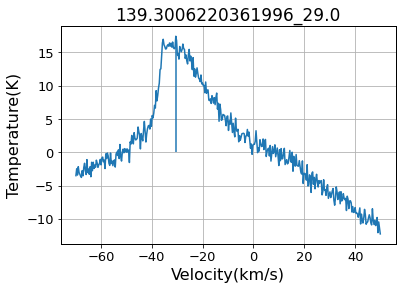

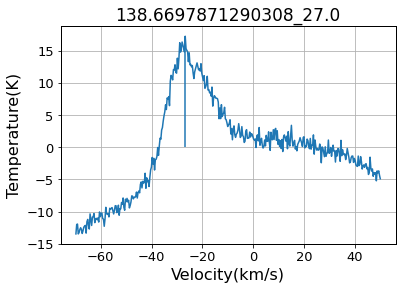

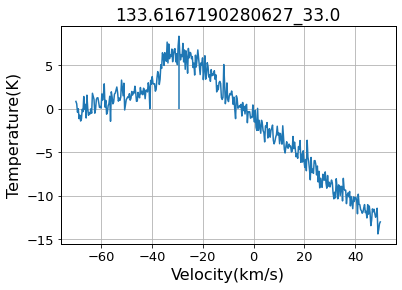

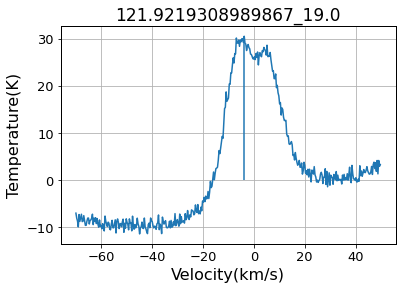

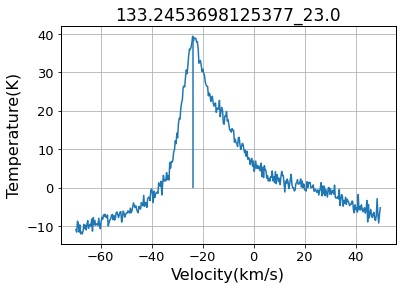

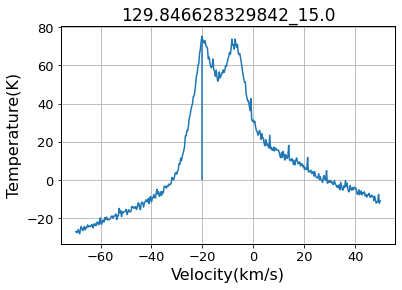

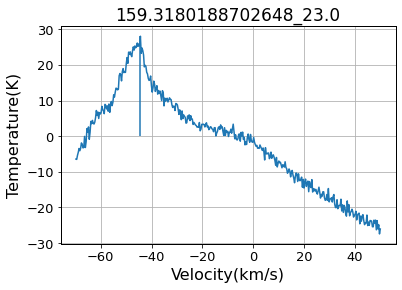

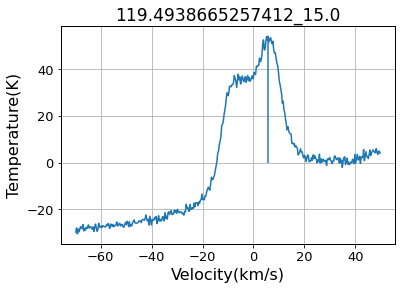

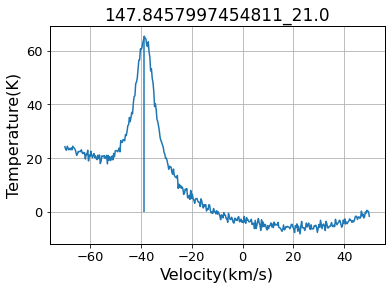

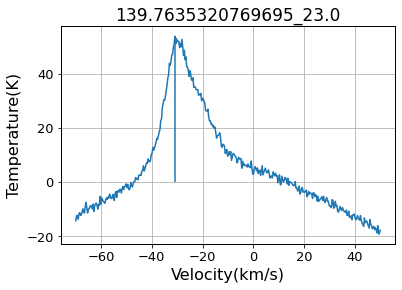

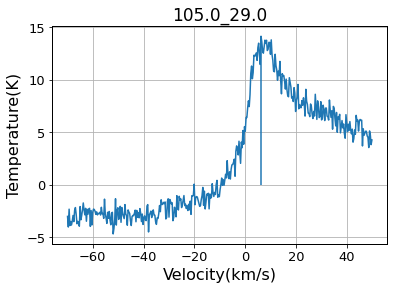

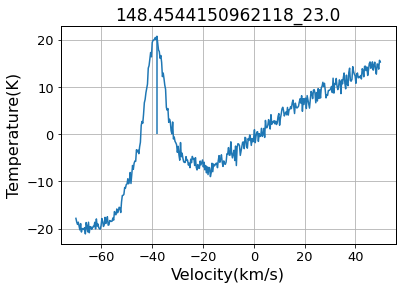

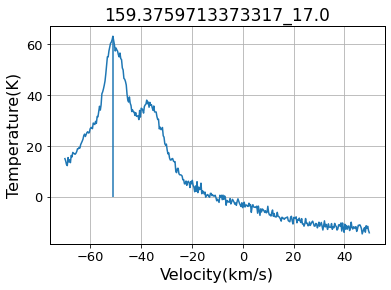

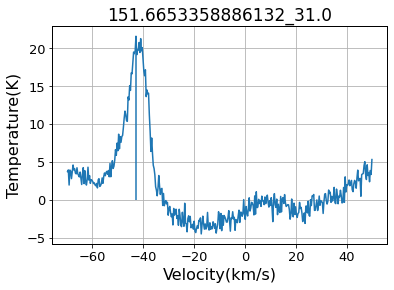

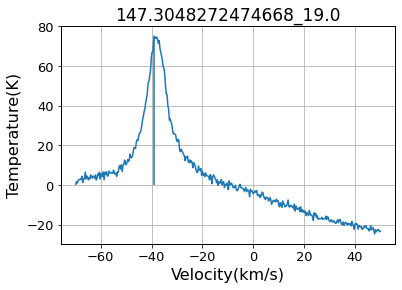

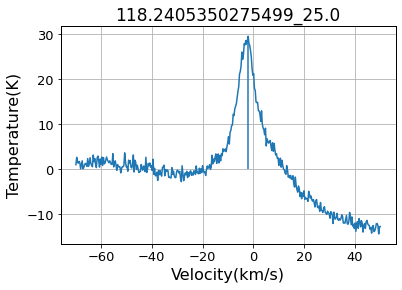

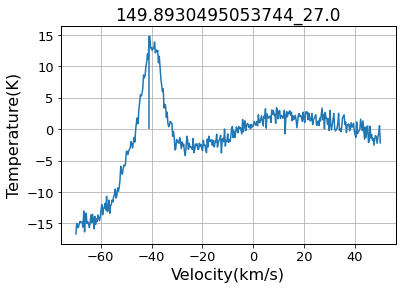

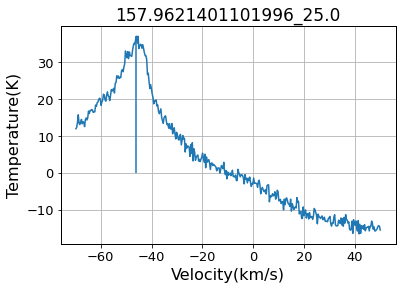

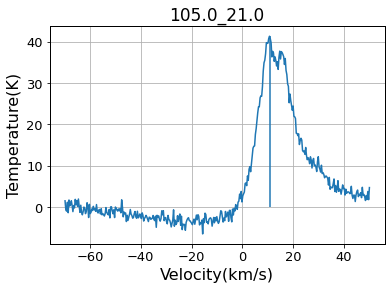

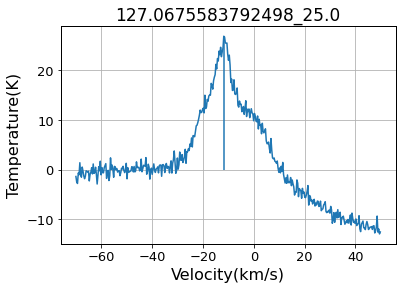

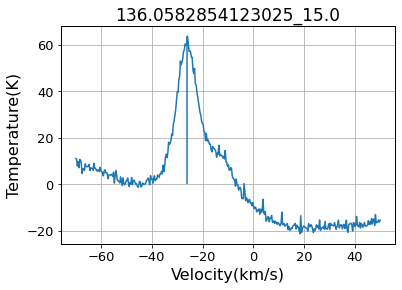

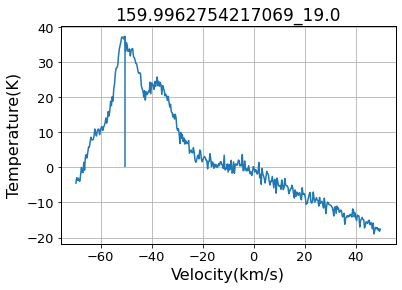

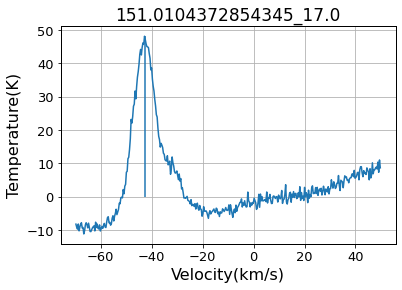

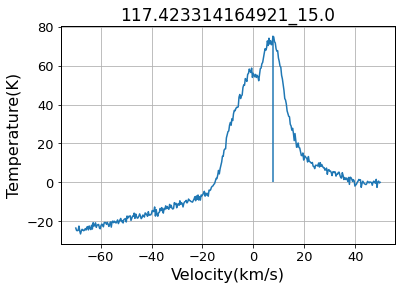

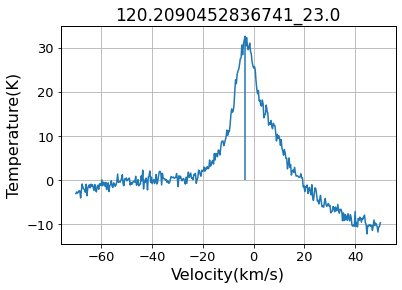

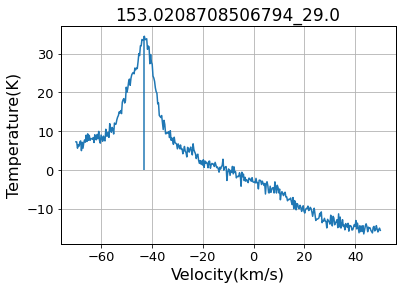

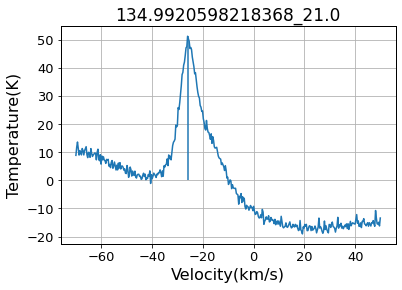

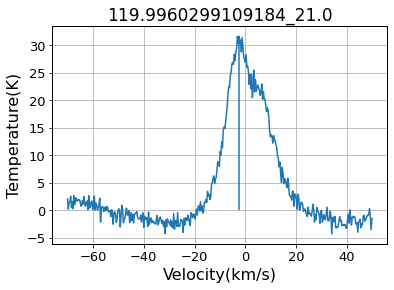

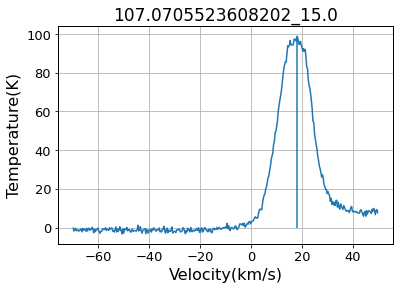

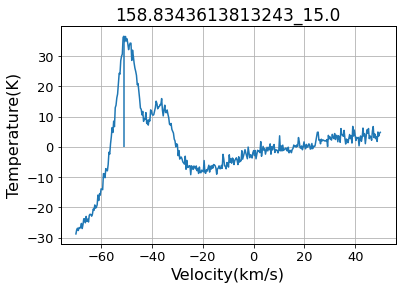

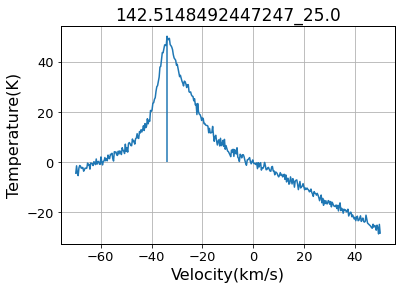

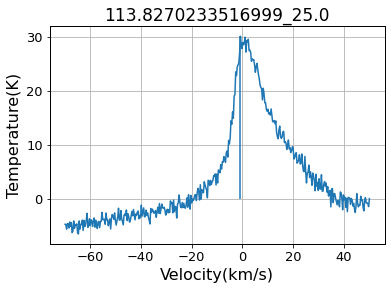

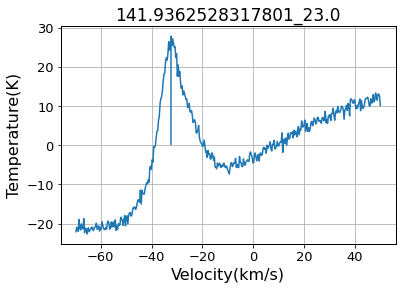

(158.8716594064493, 27.0)


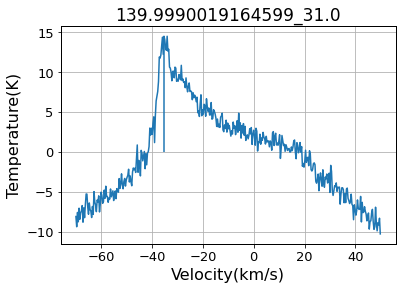

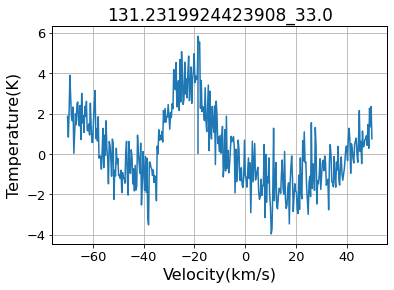

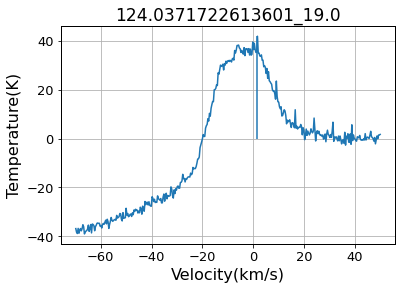

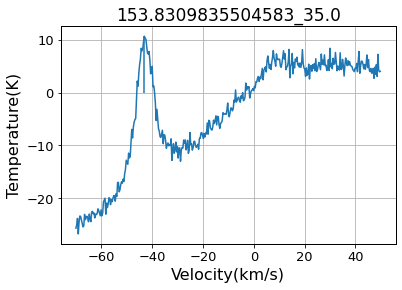

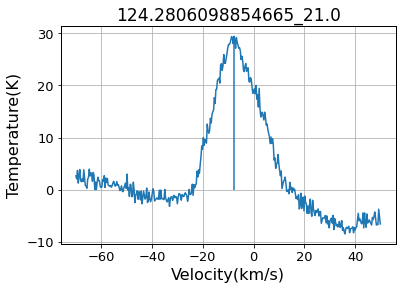

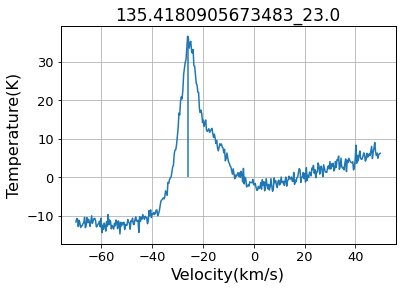

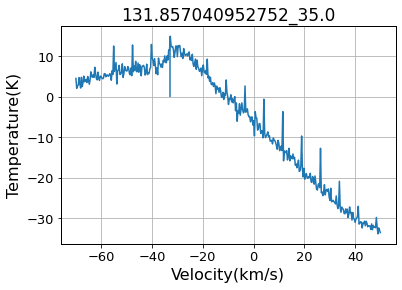

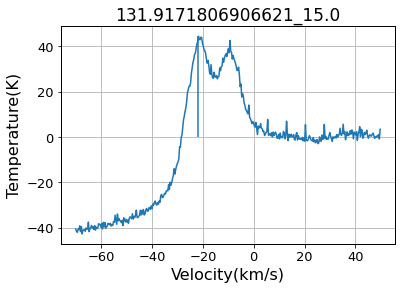

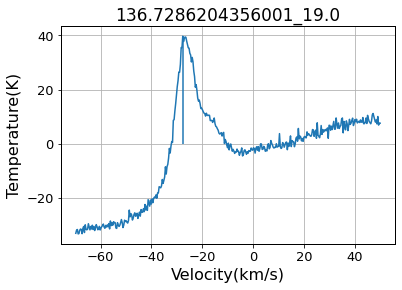

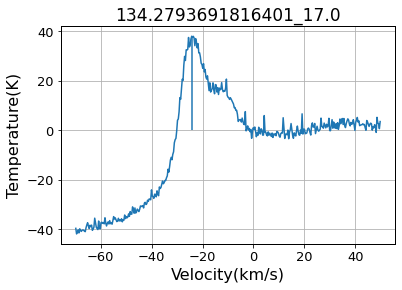

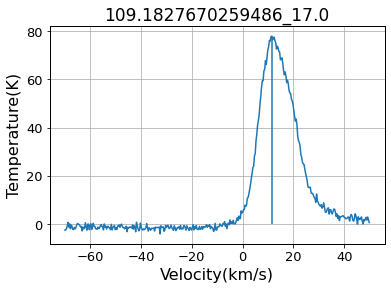

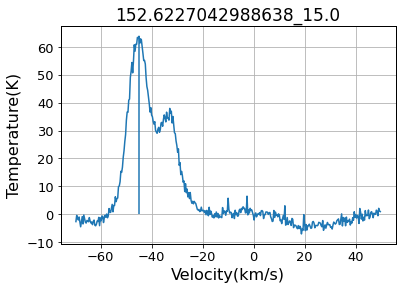

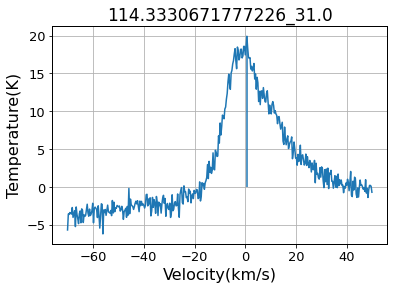

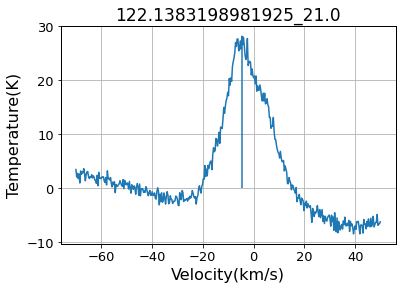

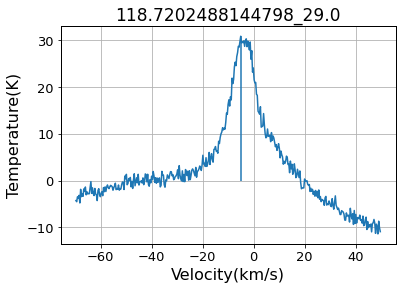

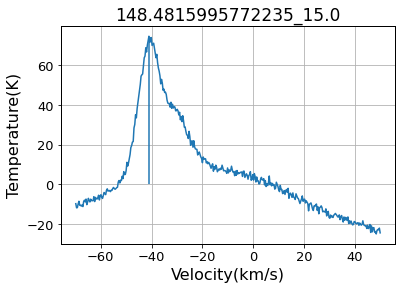

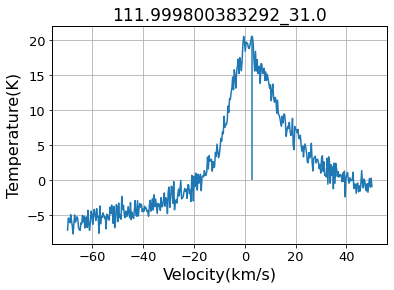

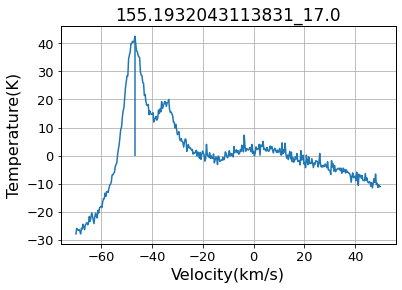

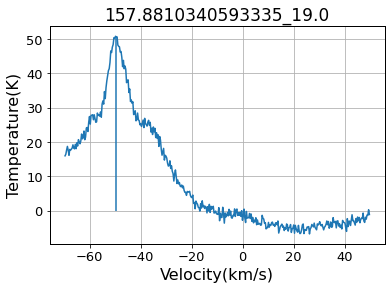

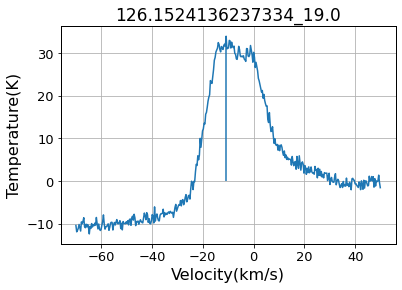

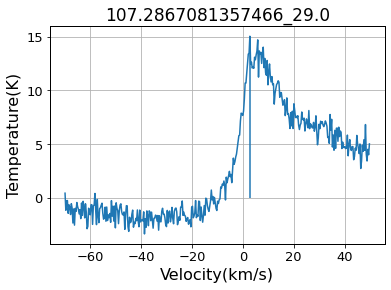

249 249


In [11]:
# RUN THIS CELL TO LOOP THROUGH ALL SPECTRA 
# SAVES ls, bs, ras, decs, jds, specs (main), and Ts which are ordered in the same order

ls = []
bs = []
ras, decs, jds = [], [], []
specs = []
Ts = []
Vs = []

for coord in data_dict.keys():
    l, b = coord
    main, noise_on, noise_off, ra, dec, jd = data_dict.get(coord)
    
    if len(main) == 0 or len(noise_on) == 0 or len(noise_off) == 0:
        print(coord)
        continue
        
    if b > 35 :
        continue
    temperature, velocity = calc_peak_max(main, noise_on, noise_off, [l, b, ra, dec, jd])
    
#     if temperature < 10:
#         continue
    ls.append(l)
    bs.append(b)
    specs.append(main)
    Ts.append(temperature)
    ras.append(ra)
    decs.append(dec)
    jds.append(jd)
    Vs.append(velocity)

#bayern13 18rway
print(len(ras), len(decs))

In [12]:
l_min, l_max = 105, 159
b_min, b_max = 15, 35
resolution = 200
lrange, brange = np.linspace(l_min, l_max, resolution), np.linspace(b_min, b_max, resolution)
print(lrange.shape, brange.shape)
Lgrid, Bgrid = np.meshgrid(lrange, brange)
print(len(ls), len(bs), len(Ts))
print(min(ls), max(ls), min(bs), max(bs))
print(lrange.max())

(200,) (200,)
249 249 249
105.0 159.9962754217069 15.0 35.0
159.0


In [13]:
bad_ls, bad_bs = [coord[0] for coord in bad_coords], [coord[1] for coord in bad_coords]

<ipython-input-22-db0cf751b65f>:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(pad=0.01)


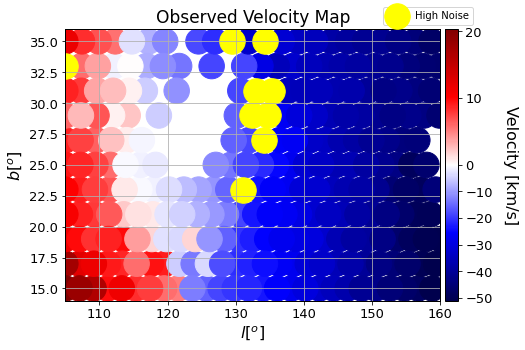

In [22]:
plt.figure(figsize=(8,5))
plt.title('Observed Velocity Map')
norm = TwoSlopeNorm(vmin=min(Vs), vcenter=0, vmax=max(Vs))
plt.scatter(ls, bs, c=Vs, cmap='seismic', norm=norm, s=650, marker='o')
cbar = plt.colorbar(pad=0.01)
cbar.set_label('Velocity [km/s]', rotation=270, labelpad=25)
plt.scatter(bad_ls, bad_bs, c='yellow', s=650, marker='o', label='High Noise')
plt.xlabel('$l [^o]$')
plt.ylabel('$b [^o]$')
plt.xlim(105, 160)
plt.legend(loc='upper right', bbox_to_anchor=(1.1,1.1))
# plt.ylim(15, 50)

<ipython-input-23-adbc4915e2f9>:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(pad=0.01)


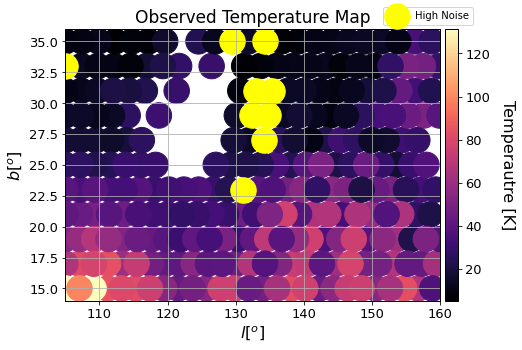

In [23]:
plt.figure(figsize=(8,5))
plt.title('Observed Temperature Map')
# norm = TwoSlopeNorm(vmin=min(Vs), vcenter=0, vmax=max(Vs))
plt.scatter(ls, bs, c=Ts, cmap='magma', s=650, marker='o')
cbar = plt.colorbar(pad=0.01)
cbar.set_label('Temperautre [K]', rotation=270, labelpad=25)
plt.scatter(bad_ls, bad_bs, c='yellow', s=650, marker='o', label='High Noise')
plt.xlabel('$l [^o]$')
plt.ylabel('$b [^o]$')
plt.xlim(105, 160)
plt.legend(loc='upper right', bbox_to_anchor=(1.1,1.1))
# plt.ylim(15, 50)

<ipython-input-16-05be9467acb8>:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax1)


Text(0.5, 1.0, 'Max Temperatures [K]')

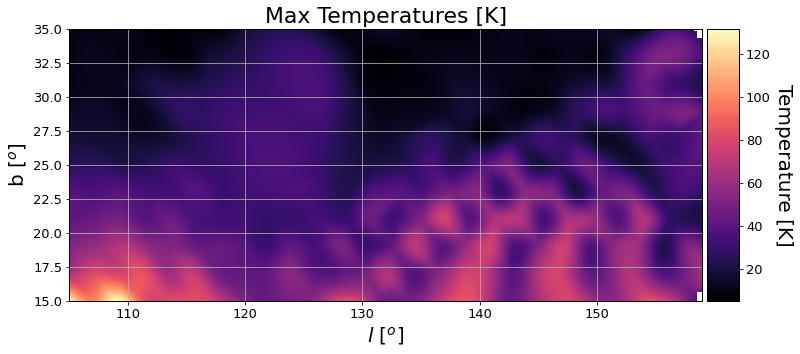

In [16]:
points = []
for i in range(len(ls)):
    points.append([ls[i],bs[i]])
grid_x, grid_y = np.mgrid[l_min:l_max:1, b_min:b_max:1]

# grid_temps = griddata(points, Ts, (grid_x, grid_y), method='cubic')
grid_temps = griddata(points, Ts, (Lgrid, Bgrid), method='cubic')

extent=[l_min, l_max, b_min, b_max]
f, ax = plt.subplots(1,1, figsize=(12,5))
im = ax.imshow(grid_temps, origin="lower", extent=extent, cmap="magma", aspect="auto")
divider1 = axgrid.make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size='5%', pad=0.07)
cbar = plt.colorbar(im, cax=cax1)
cbar.set_label('Temperature [K]', rotation=270, labelpad=22, fontsize=20)
ax.set_xlabel('$l$ [$^o$]', fontsize=20)
ax.set_ylabel('b [$^o$]', fontsize=20)
ax.set_title('Max Temperatures [K]', fontsize=22)

In [17]:
print(grid_temps.shape)

(200, 200)


In [18]:
print(grid_x)

[[105 105 105 ... 105 105 105]
 [106 106 106 ... 106 106 106]
 [107 107 107 ... 107 107 107]
 ...
 [156 156 156 ... 156 156 156]
 [157 157 157 ... 157 157 157]
 [158 158 158 ... 158 158 158]]


<ipython-input-19-7467cff277b6>:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax1)


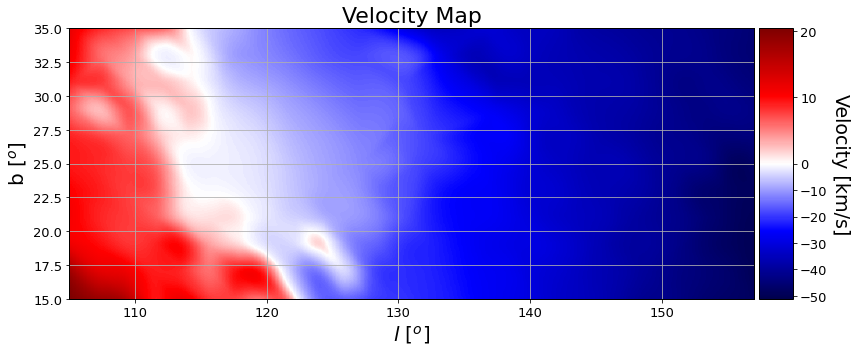

In [19]:
grid_velocity = griddata(points, Vs, (Lgrid, Bgrid), method='cubic')

norm = TwoSlopeNorm(vmin=min(Vs), vcenter=0, vmax=max(Vs))

extent=[l_min, l_max, b_min, b_max]
f, ax = plt.subplots(1,1, figsize=(12,5))
im = ax.imshow(grid_velocity, origin="lower", extent=extent, cmap="seismic", norm=norm, aspect="auto")
divider1 = axgrid.make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size='5%', pad=0.07)
cbar = plt.colorbar(im, cax=cax1)
cbar.set_label('Velocity [km/s]', rotation=270, labelpad=22, fontsize=19)
ax.set_xlabel('$l$ [$^o$]', fontsize=20)
ax.set_ylabel('b [$^o$]', fontsize=20)
ax.set_title('Velocity Map', fontsize=22)
ax.set_ylim(15, 35)
ax.set_xlim(105, 157)
plt.tight_layout()

<ipython-input-21-4d846de7536d>:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, cax=cax1)


(200, 200)


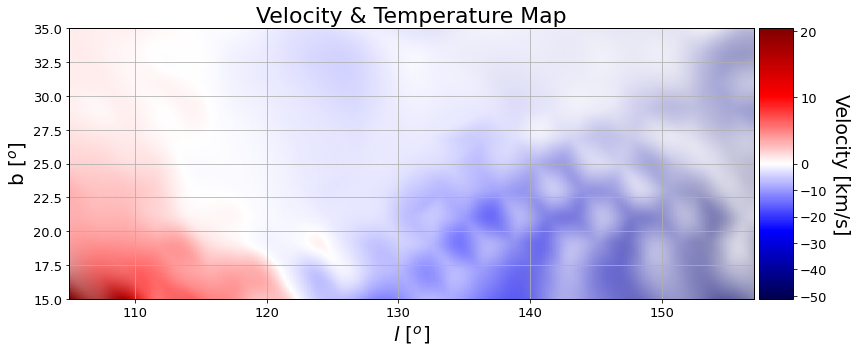

In [21]:
max_temp = np.nanmax(grid_temps)
alphas = np.zeros(grid_temps.shape)
for i in range(grid_temps.shape[0]):
    for j in range(grid_temps.shape[1]):
        if np.isnan(grid_temps[i][j]):
            continue
        alphas[i][j] = grid_temps[i][j]/max_temp

grid_velocity = griddata(points, Vs, (Lgrid, Bgrid), method='cubic')

norm = TwoSlopeNorm(vmin=min(Vs), vcenter=0, vmax=max(Vs))

extent=[l_min, l_max, b_min, b_max]
f, ax = plt.subplots(1,1, figsize=(12,5))
im = ax.imshow(grid_velocity, origin="lower", extent=extent, cmap="seismic", norm=norm, aspect="auto", alpha=alphas)
divider1 = axgrid.make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size='5%', pad=0.07)
cbar = plt.colorbar(im, cax=cax1)
cbar.set_label('Velocity [km/s]', rotation=270, labelpad=22, fontsize=19)
ax.set_xlabel('$l$ [$^o$]', fontsize=20)
ax.set_ylabel('b [$^o$]', fontsize=20)
ax.set_title('Velocity & Temperature Map', fontsize=22)
ax.set_ylim(15, 35)
ax.set_xlim(105, 157)
plt.tight_layout()
print(grid_temps.shape)